# Classification Tree

## Post-Pruning

### Preprocessing

Install packages & write a performance evaluation function

In [71]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

import graphviz 

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [72]:
# Performance Evaluation Function ------------------------------------------------
def perf_eval(cm):
    _tp = cm[1, 1]
    _fn = cm[1, 0]
    _fp = cm[0, 1]
    _tn = cm[0, 0]

    # True positive rate: TPR (Recall)
    TPR = round(_tp / (_tp + _fn),5)
    # Precision
    PRE = round(_tp/(_tp+_fp),5)
    # True negative rate: TNR
    TNR = round(_tn/(_tn+_fp),5)
    # Simple Accuracy
    ACC = round((_tp + _tn) / np.sum(cm),5)
    # Balanced Correction Rate
    BCR = round(np.sqrt(TPR*TNR),5)
    # F1-Measure
    F1 = round(2*TPR*PRE/(TPR+PRE),5)
    
    return TPR, PRE, TNR, ACC, BCR, F1

* AUROC 산출 함수

In [73]:
from sklearn.metrics import roc_auc_score

def perf_eval_with_auroc(cm, y_true, y_pred):
    # Calculate other performance metrics (same as before)
    TPR, PRE, TNR, ACC, BCR, F1 = perf_eval(cm)
    
    # Calculate AUROC
    AUROC = round(roc_auc_score(y_true, y_pred), 5)
    
    return TPR, PRE, TNR, ACC, BCR, F1, AUROC

In [74]:
# Performance table
Perf_Table = pd.DataFrame(index=["Full-tree", "Post-Pruning", "Pre-Pruning", "Pre-Pruning(CV)"],
                          columns = ["TPR", "Precision", "TNR", 
                                     "Accuracy", "BCR", "F1-Measure","AUROC"])

In [75]:
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Post-Pruning,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Pruning,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Pruning(CV),NaN,NaN,NaN,NaN,NaN,NaN,NaN


Load the dataset and set the input/target indices

In [76]:
# Load the data & Preprocessing
diabetes = pd.read_csv("diabetes.csv")

In [77]:
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [78]:
columns = diabetes.columns.values
input_idx = [0, 1, 2, 3, 4, 5, 6, 7]
target_idx = 8

diabetes_input = diabetes[columns[input_idx]]
diabetes_target = diabetes[columns[target_idx]]

In [79]:
# Normalize the input data
scaler = StandardScaler()
diabetes_input_normalized = scaler.fit_transform(diabetes_input)

In [80]:
diabetes_input_normalized

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]])

In [81]:
diabetes_target

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [82]:
print(diabetes_target.value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


In [83]:
X_train, X_temp, y_train, y_temp = train_test_split(diabetes_input_normalized, 
                                                    diabetes_target, 
                                                    train_size=0.6,
                                                    shuffle=False,
                                                    random_state=12345)

In [84]:
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, 
                                                    y_temp, 
                                                    test_size=0.5,
                                                    shuffle=False,
                                                    random_state=12345)

In [85]:
X_train

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -1.09209922, -0.05715025, ..., -0.22751266,
        -0.32579923, -0.78628618],
       [ 1.82781311,  0.84832379,  0.77001375, ...,  0.71168975,
         1.59801636,  1.51108316],
       [ 1.53084665,  0.41016376,  0.25303625, ..., -0.77326542,
        -0.03586784,  4.06371575]])

In [86]:
X_valid

array([[ 1.53084665, -0.02799627,  0.14964075, ..., -1.42055357,
         0.78862456,  1.2558199 ],
       [-0.84488505, -1.5615564 , -0.36733675, ..., -1.29363432,
        -0.16875306, -0.61611067],
       [ 1.23388019, -1.46766496,  0.04624525, ...,  0.41977549,
         0.70406123,  0.49003012],
       ...,
       [-0.25095213,  1.66204957, -0.57412775, ...,  0.1151693 ,
         0.36580794,  0.23476686],
       [ 0.93691372,  1.4742667 ,  0.97680475, ...,  0.7878413 ,
         0.95171097,  0.57511787],
       [ 0.63994726, -0.49745345,  0.56322275, ...,  0.0644016 ,
         1.22654177, -0.61611067]])

In [87]:
X_test

array([[ 2.12477957,  0.53535234,  0.25303625, ...,  0.52131088,
         0.25708367,  1.4259954 ],
       [-0.25095213, -0.46615631,  0.14964075, ..., -0.78595734,
        -0.79995787, -0.53102292],
       [ 0.63994726, -0.12188771,  1.39038675, ..., -0.41789153,
        -0.9509638 , -0.27575966],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]])

In [88]:
print(y_train.value_counts())
print(y_valid.value_counts())
print(y_test.value_counts())

Outcome
0    285
1    175
Name: count, dtype: int64
Outcome
0    116
1     38
Name: count, dtype: int64
Outcome
0    99
1    55
Name: count, dtype: int64


### Training and Evaluation (Post-Pruning)

Training and evaluating CART

In [89]:
# Classification and Regression Tree (CART) --------------------------------------
# Training the tree
clf = DecisionTreeClassifier(random_state=12345)
CART_post = clf.fit(X_train, y_train)

In [90]:
clf.score(X_train, y_train)

1.0

In [91]:
clf.score(X_test, y_test)

0.6948051948051948

In [92]:
# Prediction
CART_full_prey = clf.predict(X_test)
cm = confusion_matrix(y_test, CART_full_prey)
Perf_Table.iloc[0] = perf_eval_with_auroc(cm, y_test, CART_full_prey)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,0.63636,0.56452,0.72727,0.69481,0.6803,0.59829,0.68182
Post-Pruning,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Pruning,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Pruning(CV),NaN,NaN,NaN,NaN,NaN,NaN,NaN


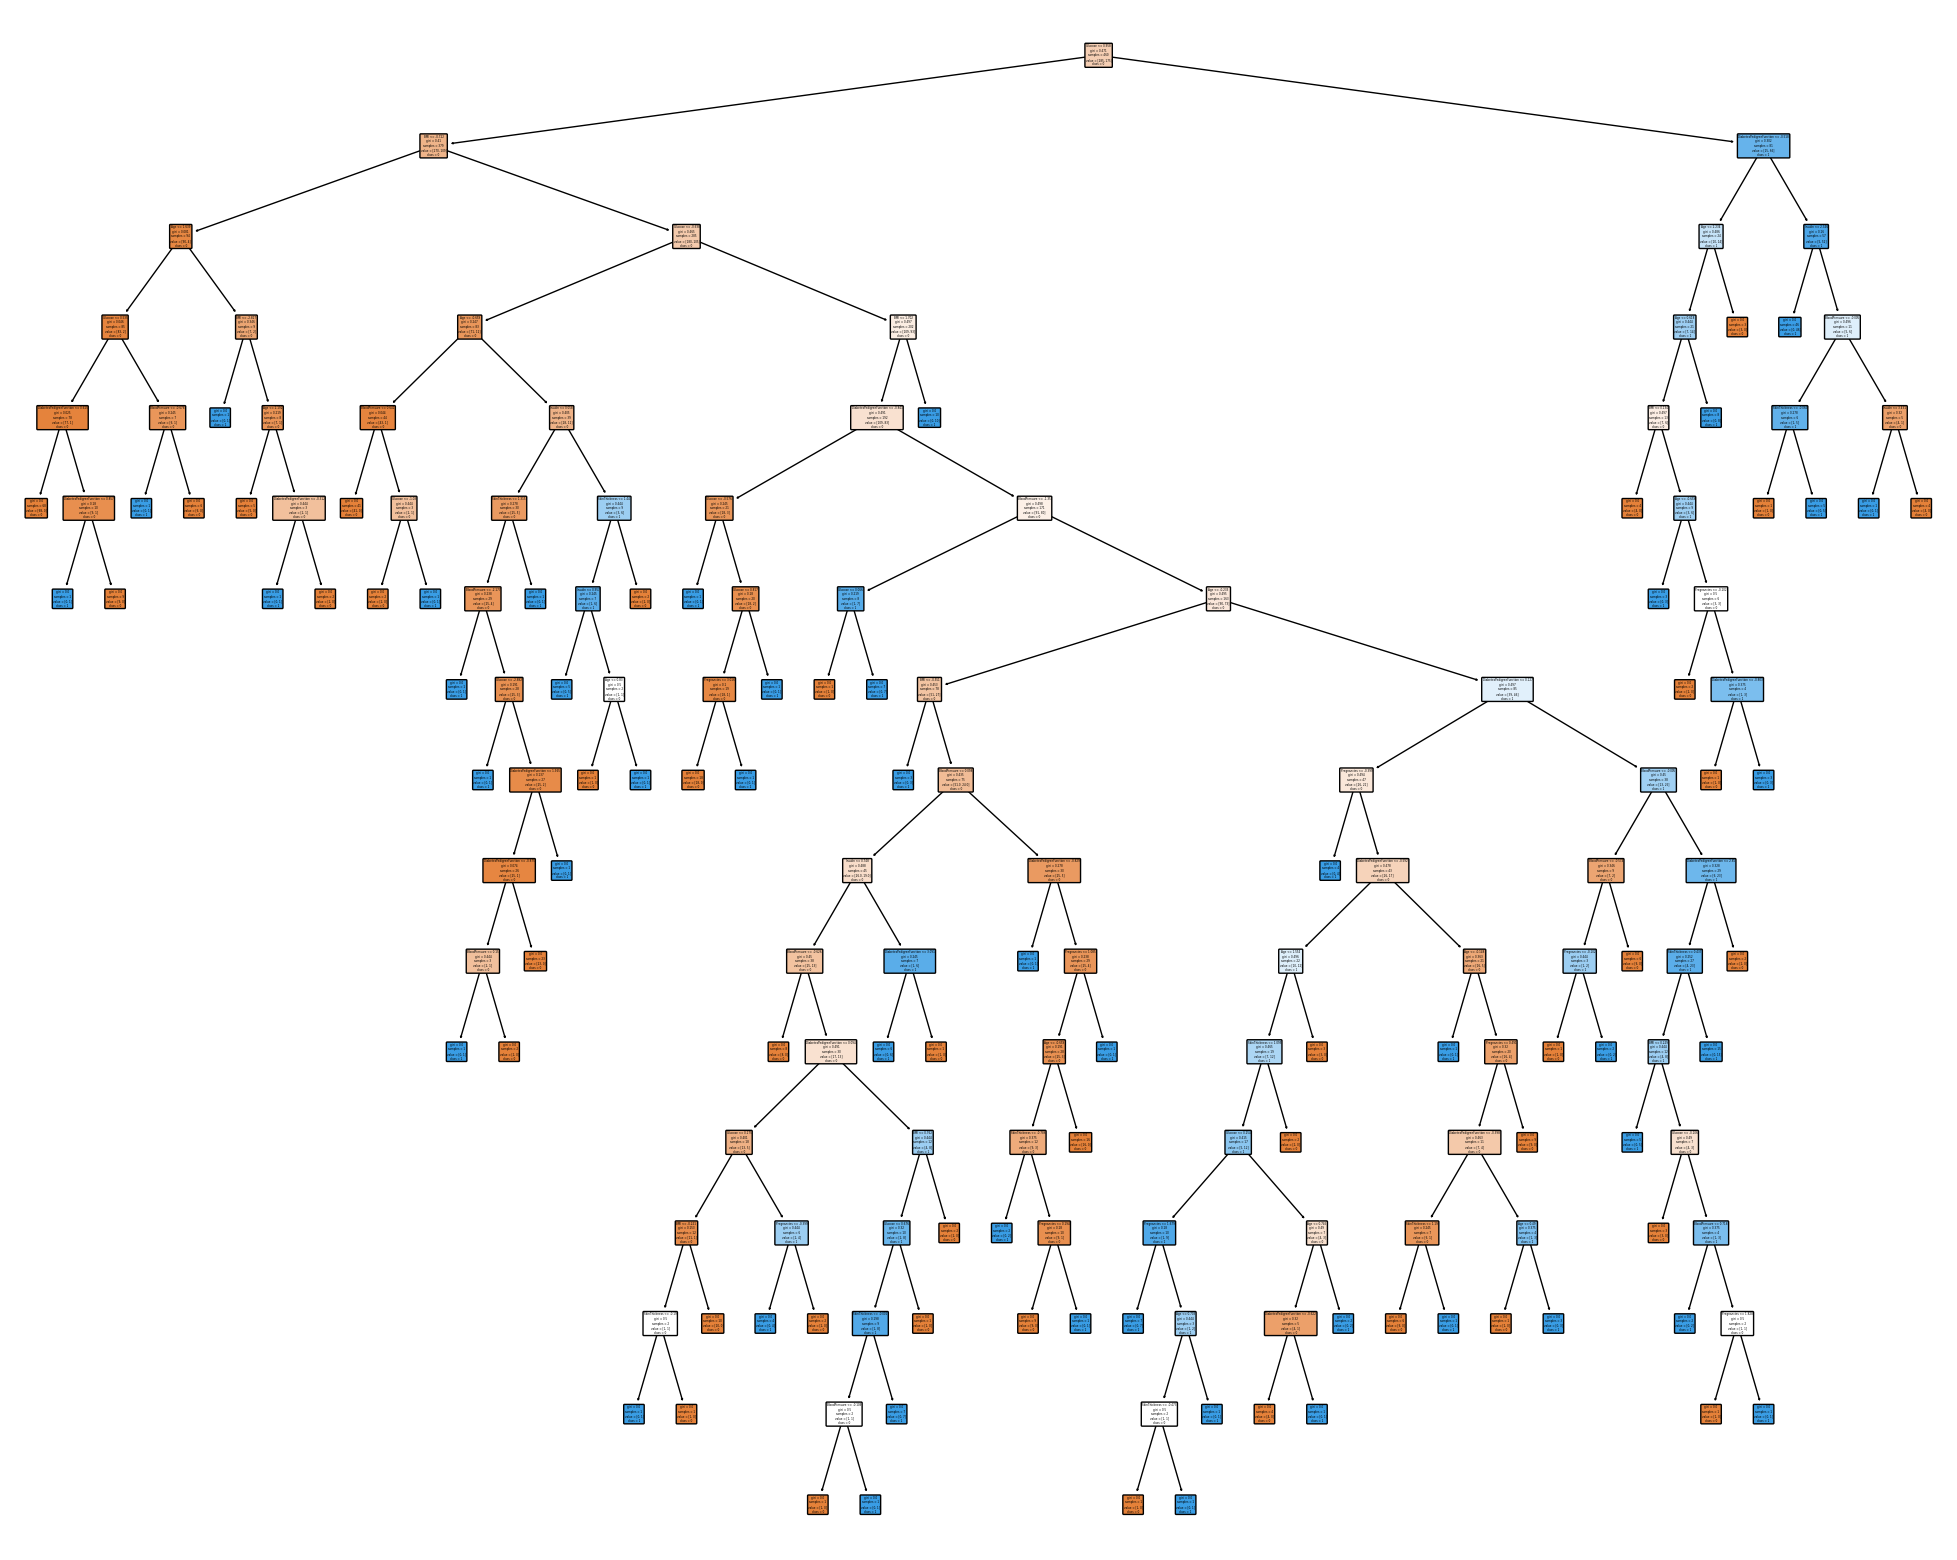

In [93]:
# Plot the tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf,
              feature_names=diabetes_input.columns.values,
              class_names=list(map(str, diabetes_target.unique()))[::-1],
              rounded=True,
              filled=True)
plt.show()

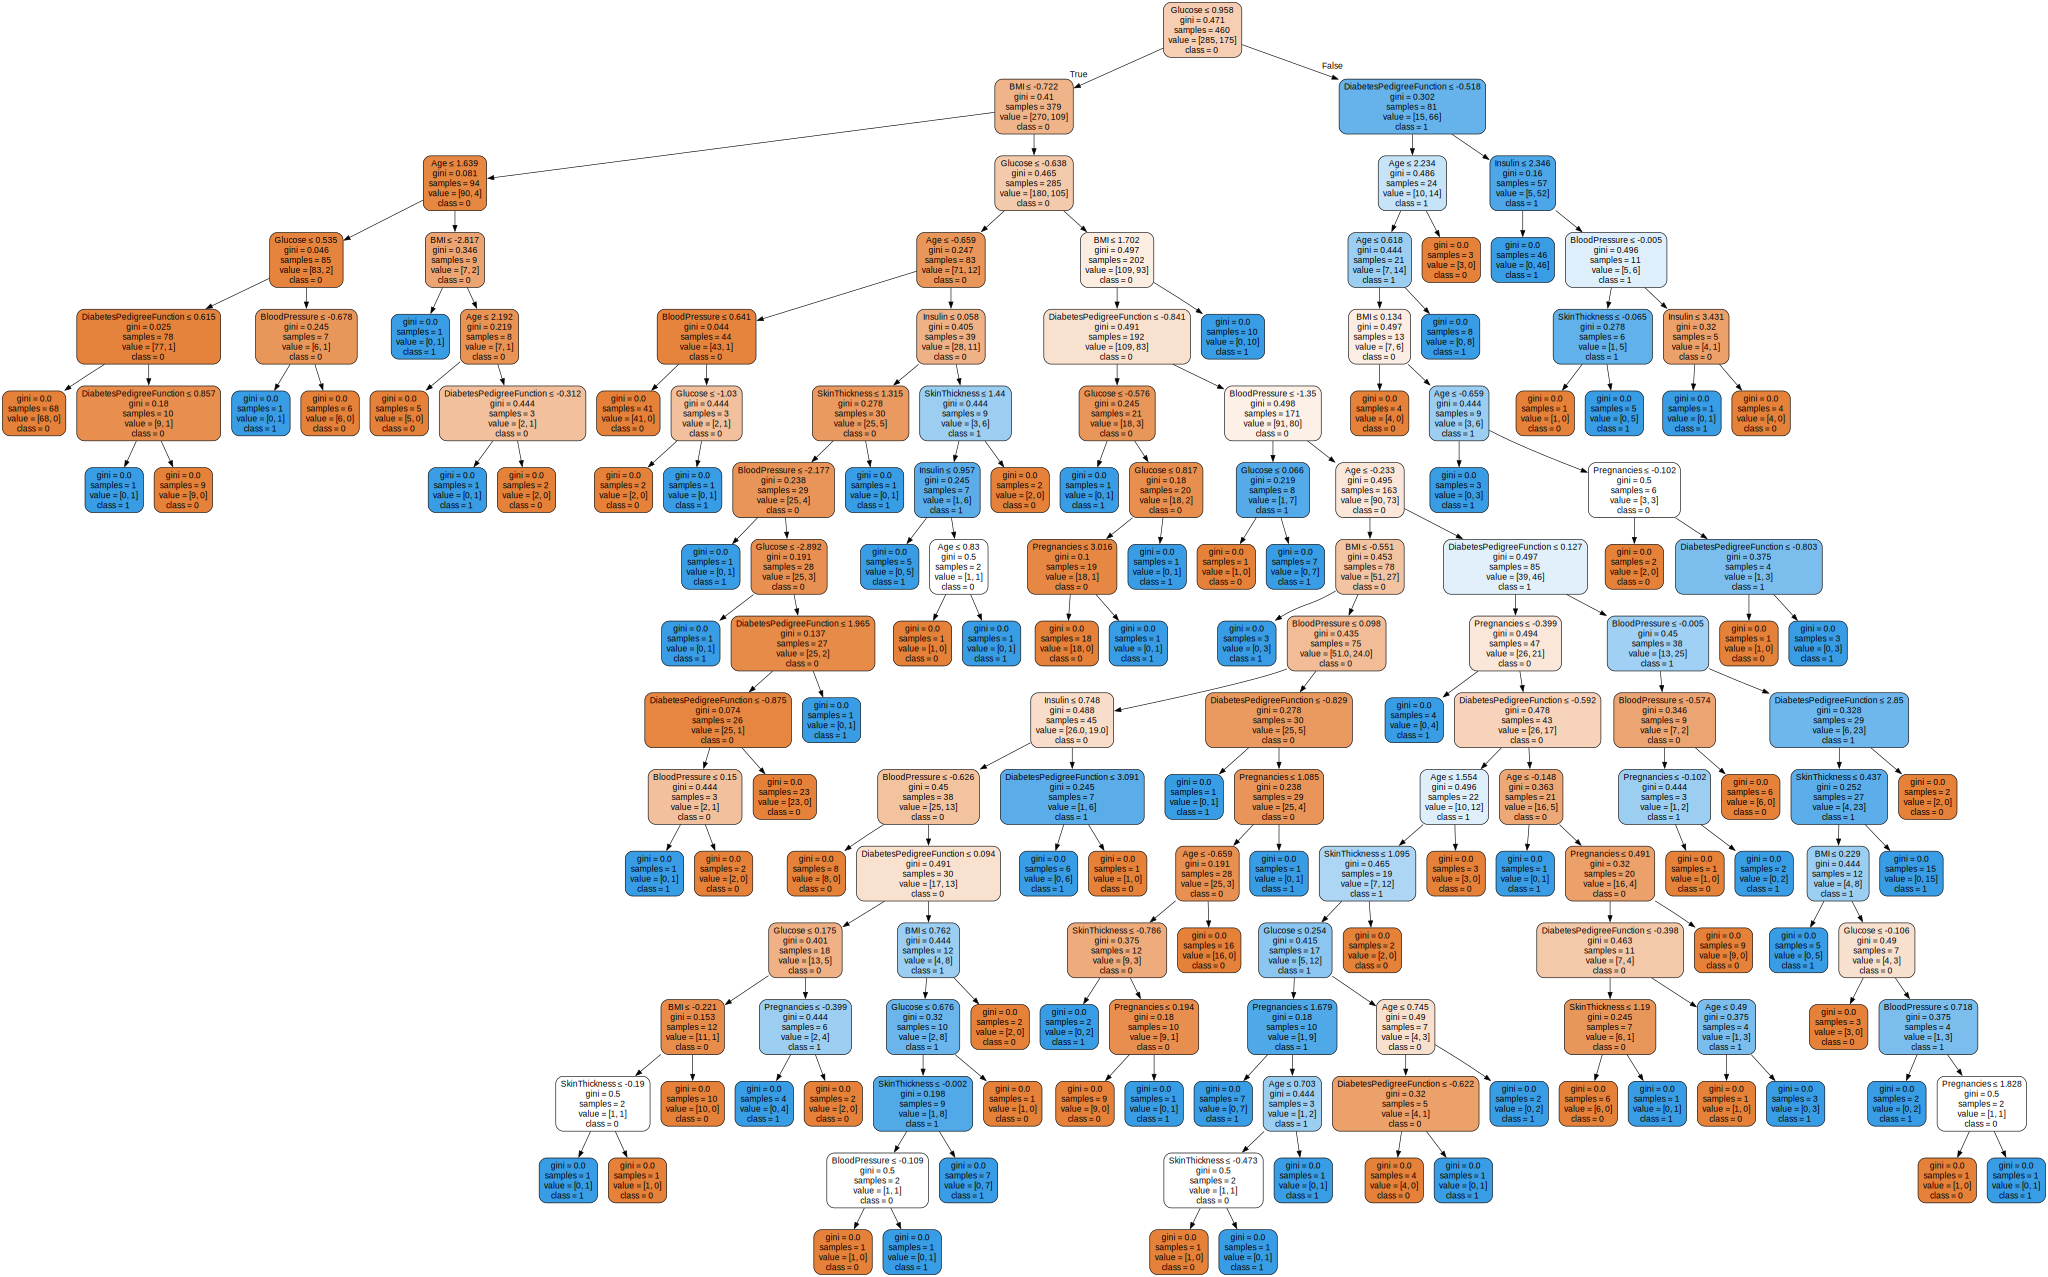

In [94]:
dot_data = export_graphviz(clf, 
                           out_file=None,
                           feature_names=diabetes_input.columns.values,
                           class_names=list(map(str, diabetes_target.unique()))[::-1],
                           filled=True,
                           rounded=True,
                           special_characters=True) 
graphviz.Source(dot_data)

Find the best tree based on cost complexity pruning

In [353]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

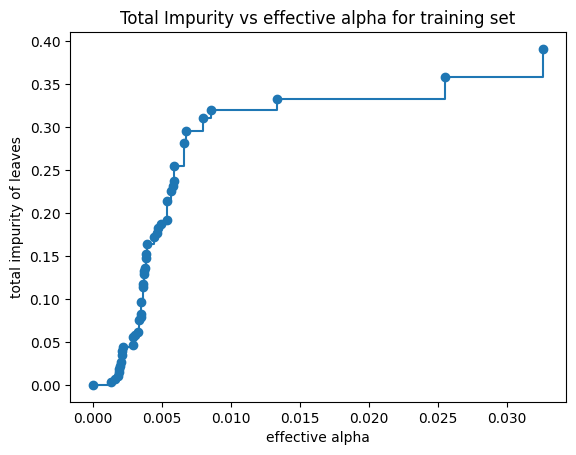

In [354]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [355]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=12345, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.08065206861599211


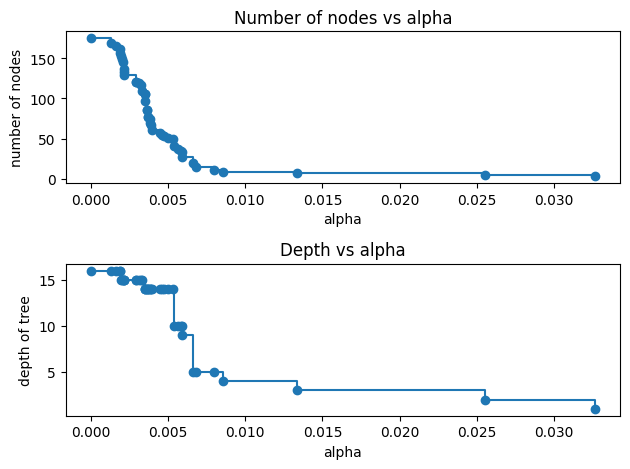

In [356]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

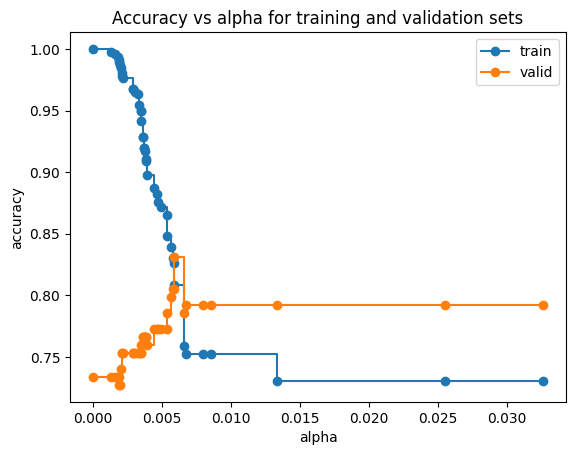

In [357]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker="o", label="valid", drawstyle="steps-post")
ax.legend()
plt.show()

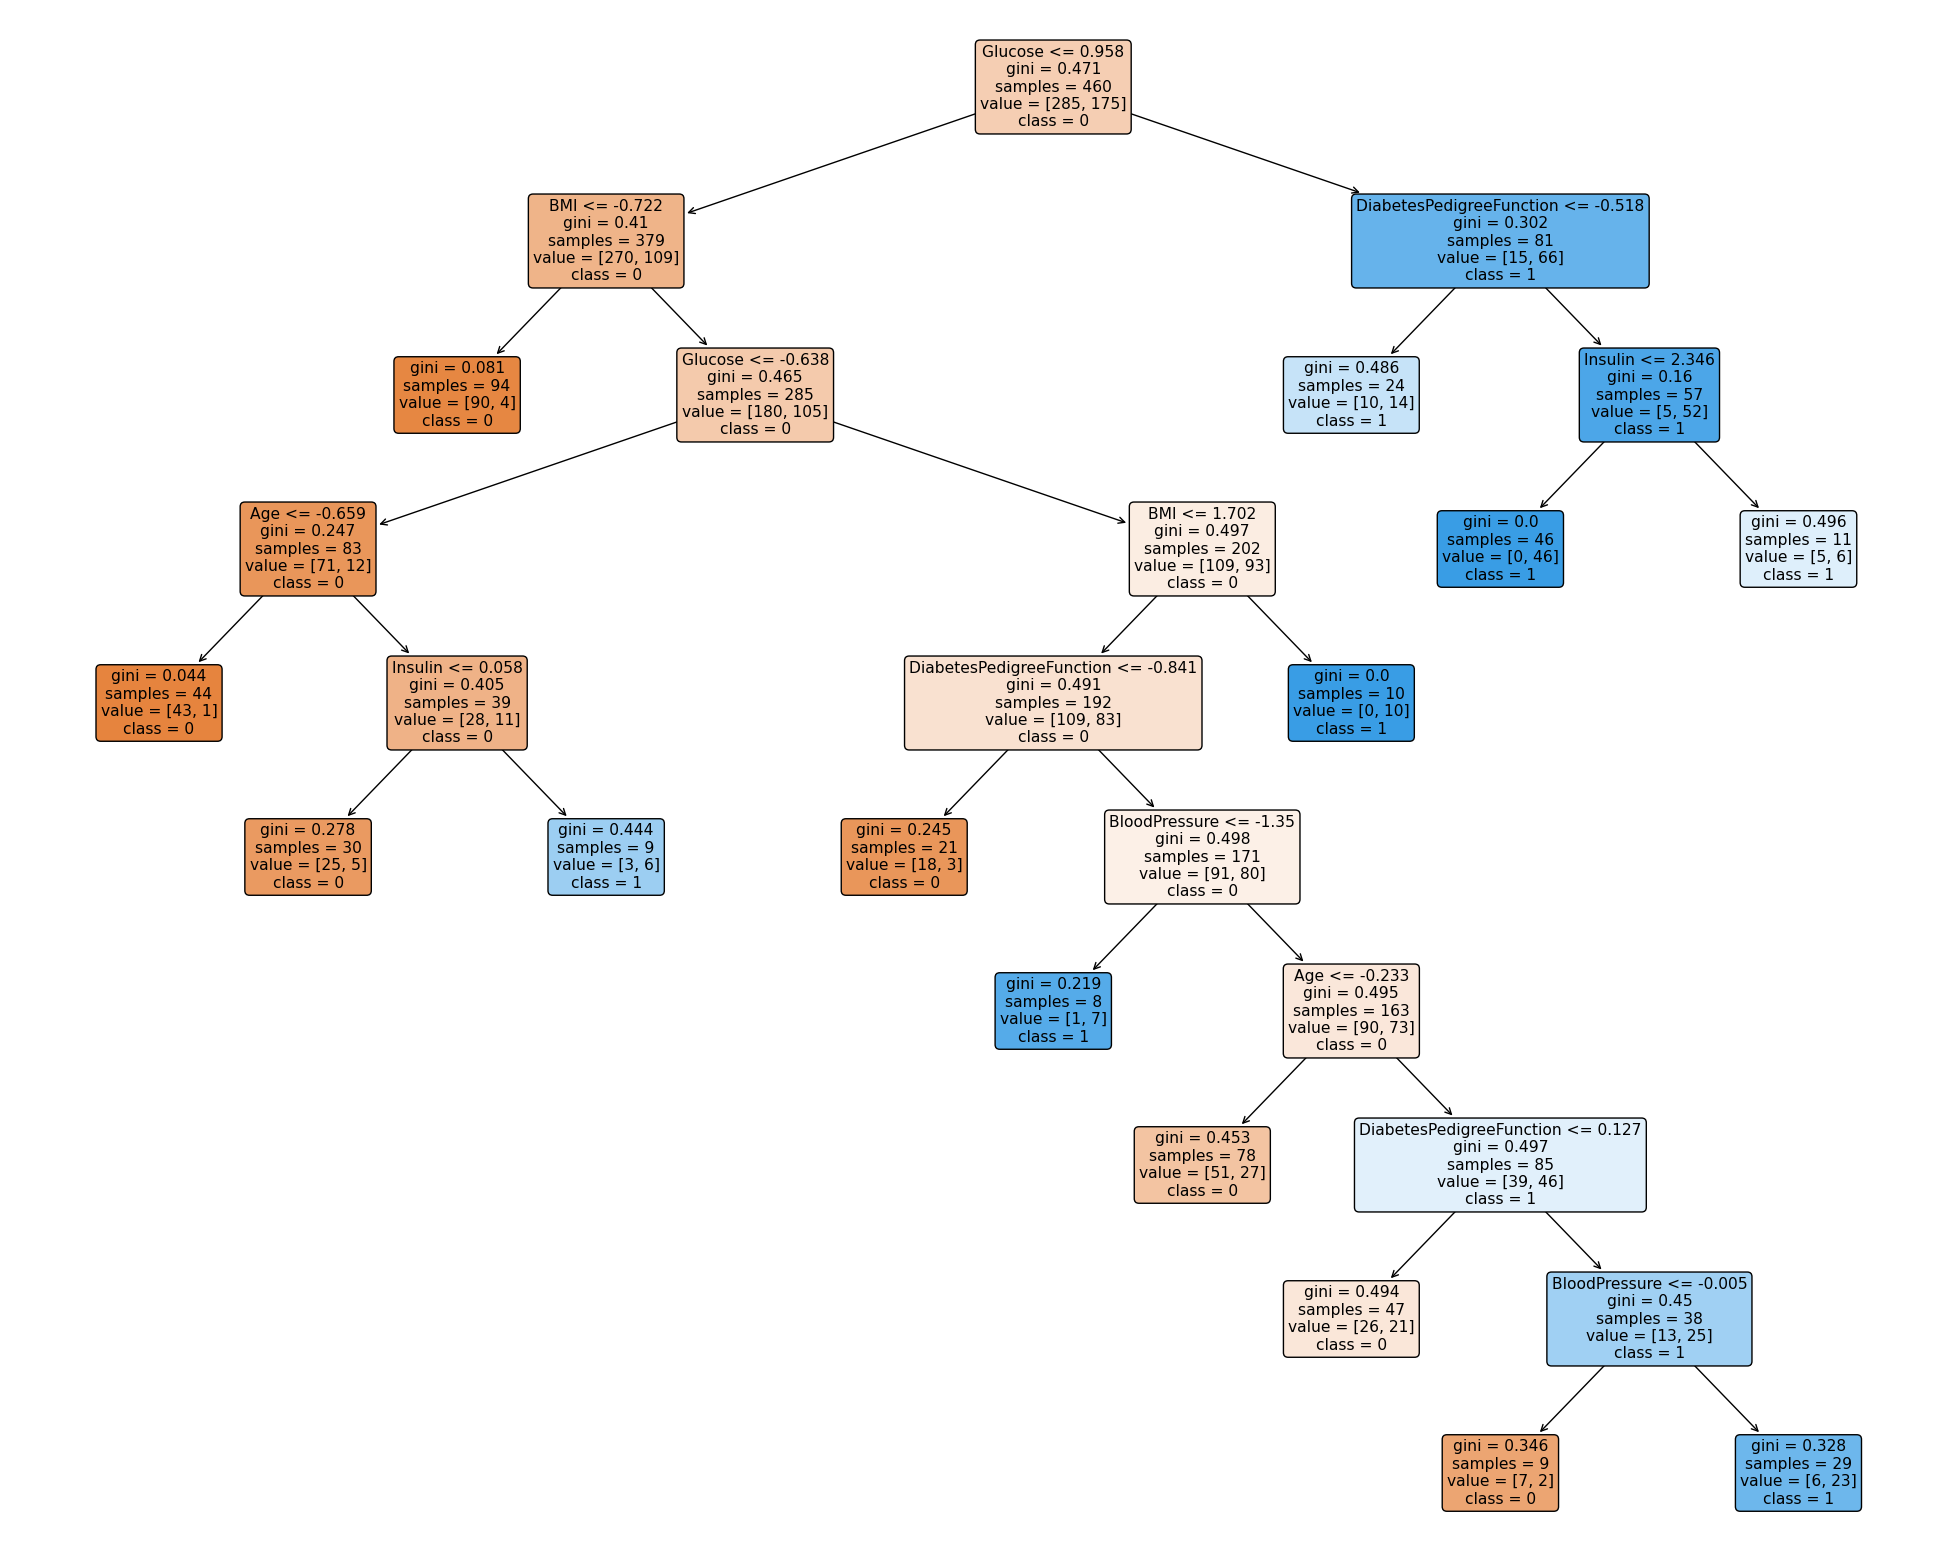

In [358]:
best_clf = clfs[np.argmax(valid_scores)]

fig = plt.figure(figsize=(25,20))
_ = plot_tree(best_clf,
              feature_names=diabetes_input.columns.values,
              class_names=list(map(str, diabetes_target.unique()))[::-1],
              rounded=True,
              filled=True)

Prediction performance with the best tree

In [359]:
# Prediction
CART_post_prey = best_clf.predict(X_test)
cm = confusion_matrix(y_test, CART_post_prey)
Perf_Table.iloc[1] = perf_eval_with_auroc(cm, y_test, CART_post_prey)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,0.63636,0.56452,0.72727,0.69481,0.6803,0.59829,0.68182
Post-Pruning,0.56364,0.70455,0.86869,0.75974,0.69973,0.62627,0.71616
Pre-Pruning,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Pruning(CV),NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pre-Pruning

### Training and Evaluation (Pre-Pruning)

Define parameter search space for pre-pruning

In [360]:
# Tree parameter settings
criterion = ["gini", "entropy", "log_loss"]
min_split = [2, 5, 10, 25, 50, 100]
max_depth = [2, 4, 8, 16]
min_samples_leaf = [1, 2, 4, 8, 16]

param_grid = {
    'criterion': criterion,
    'min_samples_split': min_split,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf
}

Find the optimal parameters

In [361]:
# 하이퍼파라미터 조합 생성
from itertools import product
param_combinations = list(product(
    param_grid['criterion'],
    param_grid['min_samples_split'],
    param_grid['max_depth'],
    param_grid['min_samples_leaf']
))

# 최적 하이퍼파라미터 및 최고 점수 초기화
best_params = None
best_score = 0

# 각 하이퍼파라미터 조합에 대해 모델 훈련 및 평가
for params in param_combinations:
    criterion, min_samples_split, max_depth, min_samples_leaf = params
    model = DecisionTreeClassifier(
        criterion=criterion,
        min_samples_split=min_samples_split,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=12345
    )
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, y_pred)
    
    if score > best_score:
        best_score = score
        best_params = params

# 최적 하이퍼파라미터 출력
best_criterion, best_split, best_depth, best_min_samples_leaf = best_params
print("Best criterion:", best_criterion)
print("Best min_samples_split:", best_split)
print("Best max_depth:", best_depth)
print("Best min_samples_leaf:", best_min_samples_leaf)

# 검증 데이터에 대한 최적 모델 평가
best_model = DecisionTreeClassifier(
    criterion=best_criterion,
    min_samples_split=best_split,
    max_depth=best_depth,
    min_samples_leaf=best_min_samples_leaf,
    random_state=12345
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
roc = roc_auc_score(y_valid, y_pred)

# 결과 출력
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best criterion: gini
Best min_samples_split: 100
Best max_depth: 8
Best min_samples_leaf: 16
Confusion matrix:
 [[104  12]
 [ 14  24]]
ROC AUC: 0.764065335753176


In [363]:
# Prediction
CART_pre_prediction = best_model.predict(X_test)
cm = confusion_matrix(y_test, CART_pre_prediction)
Perf_Table.iloc[2] = perf_eval_with_auroc(cm, y_test, CART_pre_prediction)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,0.63636,0.56452,0.72727,0.69481,0.6803,0.59829,0.68182
Post-Pruning,0.56364,0.70455,0.86869,0.75974,0.69973,0.62627,0.71616
Pre-Pruning,0.56364,0.7381,0.88889,0.77273,0.70782,0.63918,0.72626
Pre-Pruning(CV),NaN,NaN,NaN,NaN,NaN,NaN,NaN


Find the optimal parameters (CV)

In [364]:
# Fit the decision tree model and evaluate the results
model = DecisionTreeClassifier(random_state=12345)
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', refit=True)
grid.fit(X_train, y_train)

# Find the best set of parameters
best_criterion = grid.best_params_['criterion']
best_split = grid.best_params_['min_samples_split']
best_depth = grid.best_params_['max_depth']
best_min_samples_leaf = grid.best_params_['min_samples_leaf']

print("Best criterion:", best_criterion)
print("Best min_samples_split:", best_split)
print("Best max_depth:", best_depth)
print("min_samples_leaf:", best_min_samples_leaf)

# Evaluate the best model on the validation data
y_pred = grid.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
roc = roc_auc_score(y_valid, y_pred)

# Print results
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best criterion: entropy
Best min_samples_split: 100
Best max_depth: 8
min_samples_leaf: 8
Confusion matrix:
 [[96 20]
 [12 26]]
ROC AUC: 0.7558983666061706


Performance comparison

In [365]:
# Prediction
CART_pre_prediction = grid.predict(X_test)
cm = confusion_matrix(y_test, CART_pre_prediction)
Perf_Table.iloc[3] = perf_eval_with_auroc(cm, y_test, CART_pre_prediction)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,0.63636,0.56452,0.72727,0.69481,0.6803,0.59829,0.68182
Post-Pruning,0.56364,0.70455,0.86869,0.75974,0.69973,0.62627,0.71616
Pre-Pruning,0.56364,0.7381,0.88889,0.77273,0.70782,0.63918,0.72626
Pre-Pruning(CV),0.76364,0.72414,0.83838,0.81169,0.80014,0.74337,0.80101


Plot the ROC curve

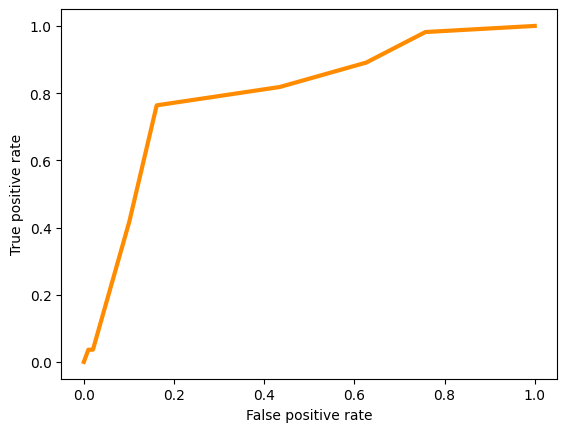

In [366]:
# Plot the ROC
CART_pre_prob = grid.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, CART_pre_prob)
plt.plot(fpr, tpr, color='darkorange', lw=3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Plot the best tree

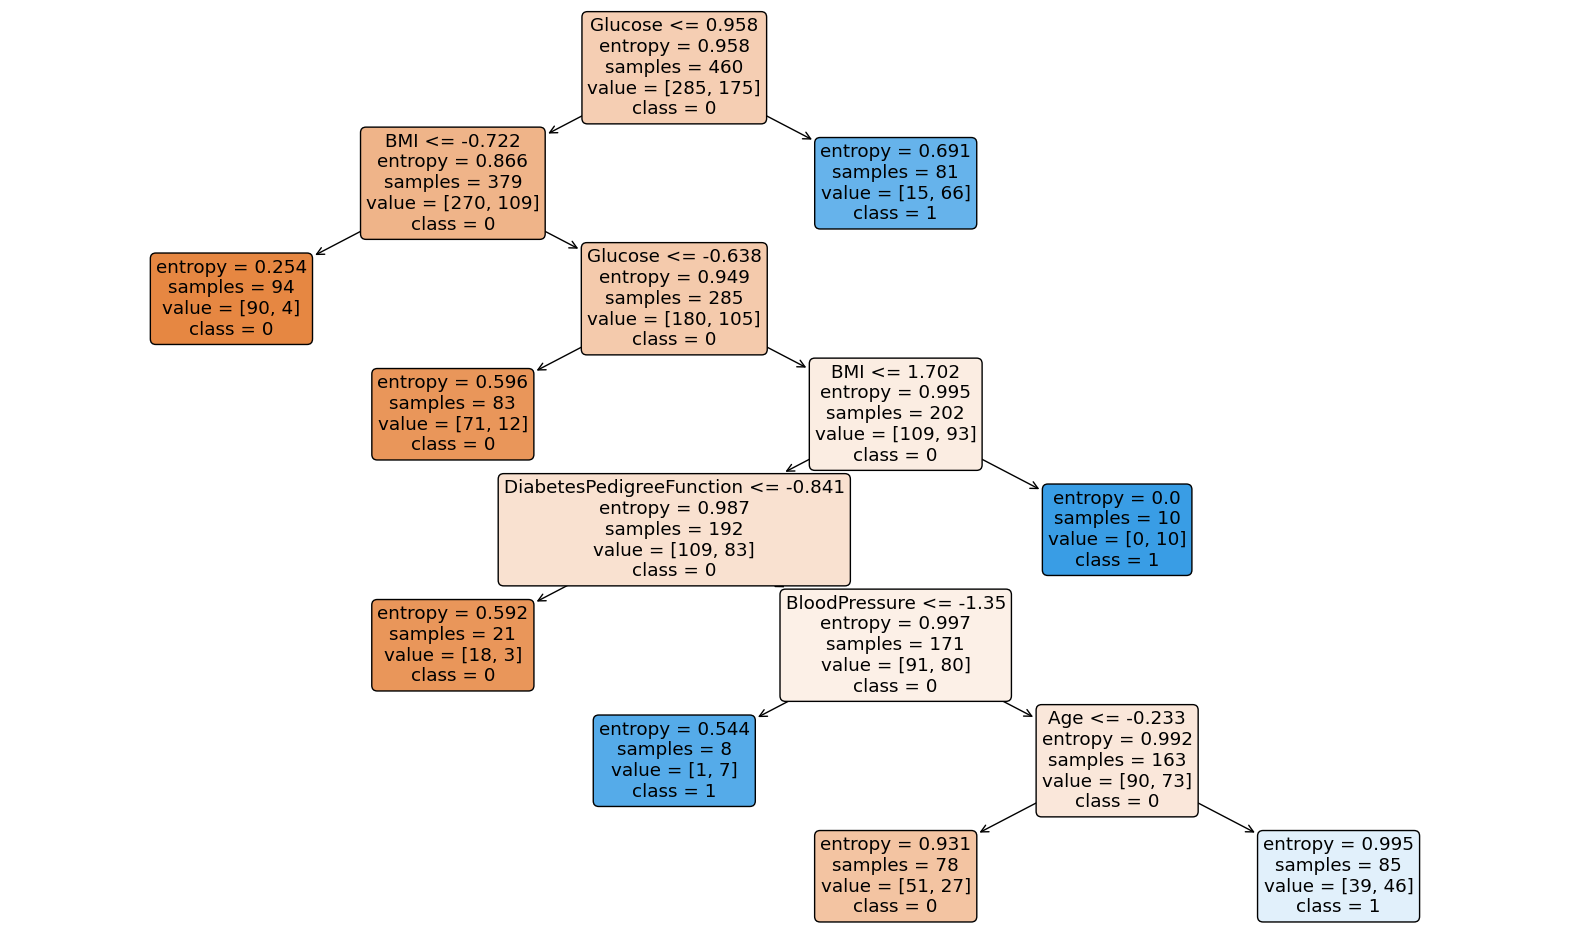

In [367]:
# Plot the best tree
CART_pre = DecisionTreeClassifier(**grid.best_params_)
CART_pre.fit(X_train,y_train)
plt.figure(figsize=(20,12))
plot_tree(CART_pre,
          feature_names=diabetes_input.columns.values,
          class_names=list(map(str, diabetes_target.unique()))[::-1],
          rounded=True,
          filled=True)
plt.show()

# Neural Networks: Python Exercise

In [371]:
# Initialize performance matrix
perf_summary = pd.DataFrame(index=["Neural_Network","Neural_Network(CV)"],
                          columns = ["TPR", "Precision", "TNR", 
                                     "Accuracy", "BCR", "F1-Measure","AUROC"])
perf_summary

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Neural_Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neural_Network(CV),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [376]:
param_grid = {
    'hidden_layer_sizes': [(20,), (50,), (100,), (200,)],  # 은닉층의 노드 수
    'learning_rate_init': [0.001, 0.01, 0.1],  # 학습률
    'activation': ['logistic', 'tanh', 'relu'],  # 활성화 함수
    'max_iter': [100, 200, 300]  # 최대 반복 횟수
}

In [377]:
from sklearn.model_selection import ParameterGrid

# 파라미터 그리드 생성
grid = ParameterGrid(param_grid)

# 검증 데이터에서 최고의 AUROC 값을 가진 모델을 찾기 위한 변수 초기화
best_auc = 0
best_params = None
best_model = None

# 각 파라미터 조합에 대해 모델 훈련 및 평가
for params in grid:
    model = MLPClassifier(random_state=12345, **params)
    model.fit(X_train, y_train)
    
    # 검증 데이터로 예측 수행
    y_pred = model.predict_proba(X_valid)[:, 1]
    
    # AUROC 계산
    auc = roc_auc_score(y_valid, y_pred)
    
    # 최고의 AUROC 값을 가진 모델 및 파라미터 저장
    if auc > best_auc:
        best_auc = auc
        best_params = params
        best_model = model

# 최적 하이퍼파라미터 출력
print("Best parameters:", best_params)
print("Best ROC AUC on validation data:", best_auc)

# 검증 데이터로 최적 모델 평가
y_pred = best_model.predict_proba(X_valid)[:, 1]
cm = confusion_matrix(y_valid, best_model.predict(X_valid))
roc = roc_auc_score(y_valid, y_pred)

# 결과 출력
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 300}
Best ROC AUC on validation data: 0.8924682395644283
Confusion matrix:
 [[103  13]
 [  9  29]]
ROC AUC: 0.8924682395644283


In [386]:
# Prediction
pred_Y = best_model.predict(X_test)
cm = confusion_matrix(y_test, pred_Y)
perf_summary.iloc[0] = perf_eval_with_auroc(cm, y_test, pred_Y)
perf_summary

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Neural_Network,0.61818,0.7234,0.86869,0.77922,0.73281,0.66666,0.74343
Neural_Network(CV),0.58182,0.69565,0.85859,0.75974,0.70678,0.63366,0.7202


Find the optimal parameters (CV)

In [379]:
# MLPClassifier 모델 정의
model = MLPClassifier(random_state=12345)

# GridSearchCV 사용
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', refit=True, verbose=2)
grid.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
best_hidden_layer_sizes = grid.best_params_['hidden_layer_sizes']
best_learning_rate_init = grid.best_params_['learning_rate_init']
best_activation = grid.best_params_['activation']
best_max_iter = grid.best_params_['max_iter']

print("Best hidden_layer_sizes:", best_hidden_layer_sizes)
print("Best learning_rate_init:", best_learning_rate_init)
print("Best activation:", best_activation)
print("Best max_iter:", best_max_iter)

# 검증 데이터로 최적 모델 평가
y_pred = grid.predict_proba(X_valid)[:, 1]
cm = confusion_matrix(y_valid, grid.predict(X_valid))
roc = roc_auc_score(y_valid, y_pred)

# 결과 출력
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=100; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=100; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=100; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=100; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=100; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=200; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=200; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=200; total time=   0.2s
[CV] END activati

In [387]:
# Prediction
pred_Y = grid.predict(X_test)
cm = confusion_matrix(y_test, pred_Y)
perf_summary.iloc[1] = perf_eval_with_auroc(cm, y_test, pred_Y)
perf_summary

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Neural_Network,0.61818,0.7234,0.86869,0.77922,0.73281,0.66666,0.74343
Neural_Network(CV),0.58182,0.69565,0.85859,0.75974,0.70678,0.63366,0.7202


### Training the model - Logistic Regression

* Logistic regression model from sklearn.linear_models [[Docs]('https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html')]
* Main arguments  
    * fit_intercept: 상수항 추가 여부 (default: True) 
    * solver : 최적해를 구하기 위한 알고리즘 / 데이터셋이 크지 않고 이진분류 과업을 진행하기 때문에 안내에 따라 'libnear' 선택
    * random_state : 랜덤성을 고정하기 위한 seed / 'solver'에서 'libnear'를 선택했을 시 사용됨 
    * max_iter: solver가 수렴하기 위한 최대 시도 횟수 

In [22]:
# Initialize performance matrix
perf_logistic = pd.DataFrame(index=["Logistic_Regression"],
                          columns = ["TPR", "Precision", "TNR", 
                                     "Accuracy", "BCR", "F1-Measure","AUROC"])
perf_logistic

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Logistic_Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# model setting
from sklearn.linear_model import LogisticRegression
full_lr = LogisticRegression(
    solver='liblinear',
    random_state=12345,
    max_iter=100000
)

# Train the model with trainset
full_lr.fit(X_train,y_train)

LogisticRegression(max_iter=100000, random_state=12345, solver='liblinear')

In [28]:
from sklearn.metrics import confusion_matrix

# 학습 데이터
lr_target_trn = y_train
lr_response_trn = full_lr.predict(X_train)
cm = confusion_matrix(lr_target_trn,lr_response_trn)
cm

array([[244,  41],
       [ 72, 103]], dtype=int64)

In [29]:
# Prediction (테스트 데이터)
pred_Y = full_lr.predict(X_test)
cm = confusion_matrix(y_test, pred_Y)
cm

array([[88, 11],
       [23, 32]], dtype=int64)

In [30]:
perf_logistic.iloc[0] = perf_eval_with_auroc(cm, y_test, pred_Y)
perf_logistic

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Logistic_Regression,0.58182,0.74419,0.88889,0.77922,0.71915,0.65306,0.73535


## Mushroom 데이터

In [121]:
# Performance table
Perf_Table = pd.DataFrame(index=["Full-tree", "Post-Pruning", "Pre-Pruning", "Pre-Pruning(CV)"],
                          columns = ["TPR", "Precision", "TNR", 
                                     "Accuracy", "BCR", "F1-Measure","AUROC"])

In [122]:
# Load the data & Preprocessing
mushroom = pd.read_csv("mushroom_cleaned.csv")
columns = mushroom.columns.values
input_idx = [0, 1, 2, 3, 4, 5, 6, 7]
target_idx = 8

mushroom_input = mushroom[columns[input_idx]]
mushroom_target = mushroom[columns[target_idx]]

In [123]:
print(mushroom_target.value_counts())

class
1    29675
0    24360
Name: count, dtype: int64


In [124]:
new_mushroom = mushroom.sample(n=2000, random_state=42)
columns = new_mushroom.columns.values
input_idx = [0, 1, 2, 3, 4, 5, 6, 7]
target_idx = 8

mushroom_input = new_mushroom[columns[input_idx]]
mushroom_target = new_mushroom[columns[target_idx]]

print(new_mushroom)

       cap-diameter  cap-shape  gill-attachment  gill-color  stem-height  \
14085           826          2                0          10     0.044195   
19006           571          6                2           4     0.536738   
50623          1122          2                0           0     0.450051   
41819           278          2                0           4     0.190566   
8085            735          2                6          10     1.455884   
...             ...        ...              ...         ...          ...   
14529           673          6                5          10     0.079154   
29116           956          5                1           7     0.950553   
37968           643          6                0          11     0.044195   
37727           695          6                5           5     0.203354   
53599           536          1                3           2     0.214440   

       stem-width  stem-color    season  class  
14085        2433           6  1.80427

In [125]:
print(mushroom_target.value_counts())

class
1    1078
0     922
Name: count, dtype: int64


In [126]:
# Normalize the input data
scaler = StandardScaler()
mushroom_input_normalized = scaler.fit_transform(mushroom_input)

In [127]:
mushroom_input_normalized

array([[ 7.13820559e-01, -9.27448679e-01, -9.66026322e-01, ...,
         1.75176609e+00, -7.75974919e-01,  2.77875900e+00],
       [ 2.23660603e-03,  9.29305433e-01, -8.03730357e-02, ...,
        -3.77693079e-01, -1.39428163e+00, -2.01350415e-02],
       [ 1.53981605e+00, -9.27448679e-01, -9.66026322e-01, ...,
         1.12642850e+00,  7.69791852e-01, -2.01350415e-02],
       ...,
       [ 2.03154428e-01,  9.29305433e-01, -9.66026322e-01, ...,
        -5.99299475e-01,  1.07894521e+00, -2.01350415e-02],
       [ 3.48261744e-01,  9.29305433e-01,  1.24810689e+00, ...,
        -3.29296280e-01, -7.75974919e-01,  2.77875900e+00],
       [-9.54317796e-02, -1.39163721e+00,  3.62453607e-01, ...,
         1.20539170e+00, -7.75974919e-01, -2.99697274e+00]])

In [128]:
X_train, X_temp, y_train, y_temp = train_test_split(mushroom_input_normalized, 
                                                    mushroom_target, 
                                                    train_size=0.6,
                                                    shuffle=False,
                                                    random_state=12345)

In [129]:
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, 
                                                    y_temp, 
                                                    test_size=0.5,
                                                    shuffle=False,
                                                    random_state=12345)

In [130]:
X_train

array([[ 7.13820559e-01, -9.27448679e-01, -9.66026322e-01, ...,
         1.75176609e+00, -7.75974919e-01,  2.77875900e+00],
       [ 2.23660603e-03,  9.29305433e-01, -8.03730357e-02, ...,
        -3.77693079e-01, -1.39428163e+00, -2.01350415e-02],
       [ 1.53981605e+00, -9.27448679e-01, -9.66026322e-01, ...,
         1.12642850e+00,  7.69791852e-01, -2.01350415e-02],
       ...,
       [-7.59576802e-01, -4.63260151e-01,  3.62453607e-01, ...,
        -1.34690266e+00, -2.01258834e+00, -2.99697274e+00],
       [-1.10002089e+00, -1.85582573e+00, -9.66026322e-01, ...,
        -9.86473869e-01, -7.75974919e-01, -2.01350415e-02],
       [ 4.90578534e-01,  4.65116905e-01,  1.69093354e+00, ...,
         2.57833311e-01,  1.07894521e+00, -2.01350415e-02]])

In [131]:
X_valid

array([[-1.03025776e+00, -9.27448679e-01, -5.23199679e-01, ...,
        -5.85289876e-01,  7.69791852e-01, -1.98078704e-01],
       [-7.53995751e-01, -9.27448679e-01,  1.69093354e+00, ...,
        -1.01449307e+00, -7.75974919e-01, -1.98078704e-01],
       [ 9.71144664e-02,  9.28377056e-04, -8.03730357e-02, ...,
         6.41186905e-01,  7.69791852e-01, -2.01350415e-02],
       ...,
       [ 3.57229097e-02,  9.29305433e-01,  1.69093354e+00, ...,
         3.71183709e-01,  7.69791852e-01, -1.98078704e-01],
       [ 7.64050014e-01,  9.29305433e-01, -8.03730357e-02, ...,
         4.71798108e-01,  7.69791852e-01, -2.01350415e-02],
       [-4.63781120e-01,  9.29305433e-01, -9.66026322e-01, ...,
        -4.55382678e-01,  7.69791852e-01, -1.98078704e-01]])

In [132]:
X_test

array([[ 0.59103745, -0.92744868,  1.69093354, ...,  0.02094371,
         0.76979185, -0.02013504],
       [ 1.03473097, -0.92744868, -0.96602632, ...,  1.1302493 ,
         0.76979185, -0.02013504],
       [-0.79027258, -1.85582573, -0.96602632, ..., -1.07817307,
        -1.70343498, -0.1980787 ],
       ...,
       [ 0.20315443,  0.92930543, -0.96602632, ..., -0.59929948,
         1.07894521, -0.02013504],
       [ 0.34826174,  0.92930543,  1.24810689, ..., -0.32929628,
        -0.77597492,  2.778759  ],
       [-0.09543178, -1.39163721,  0.36245361, ...,  1.2053917 ,
        -0.77597492, -2.99697274]])

In [133]:
print(y_train.value_counts())
print(y_valid.value_counts())
print(y_test.value_counts())

class
1    638
0    562
Name: count, dtype: int64
class
1    218
0    182
Name: count, dtype: int64
class
1    222
0    178
Name: count, dtype: int64


In [134]:
# Classification and Regression Tree (CART) --------------------------------------
# Training the tree
clf = DecisionTreeClassifier(random_state=12345)
CART_post = clf.fit(X_train, y_train)

In [135]:
clf.score(X_train, y_train)

1.0

In [136]:
clf.score(X_test, y_test)

0.82

In [137]:
# Prediction
CART_full_prey = clf.predict(X_test)
cm = confusion_matrix(y_test, CART_full_prey)
Perf_Table.iloc[0] = perf_eval_with_auroc(cm, y_test, CART_full_prey)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,0.86036,0.82328,0.76966,0.82,0.81375,0.84141,0.81501
Post-Pruning,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Pruning,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Pruning(CV),NaN,NaN,NaN,NaN,NaN,NaN,NaN


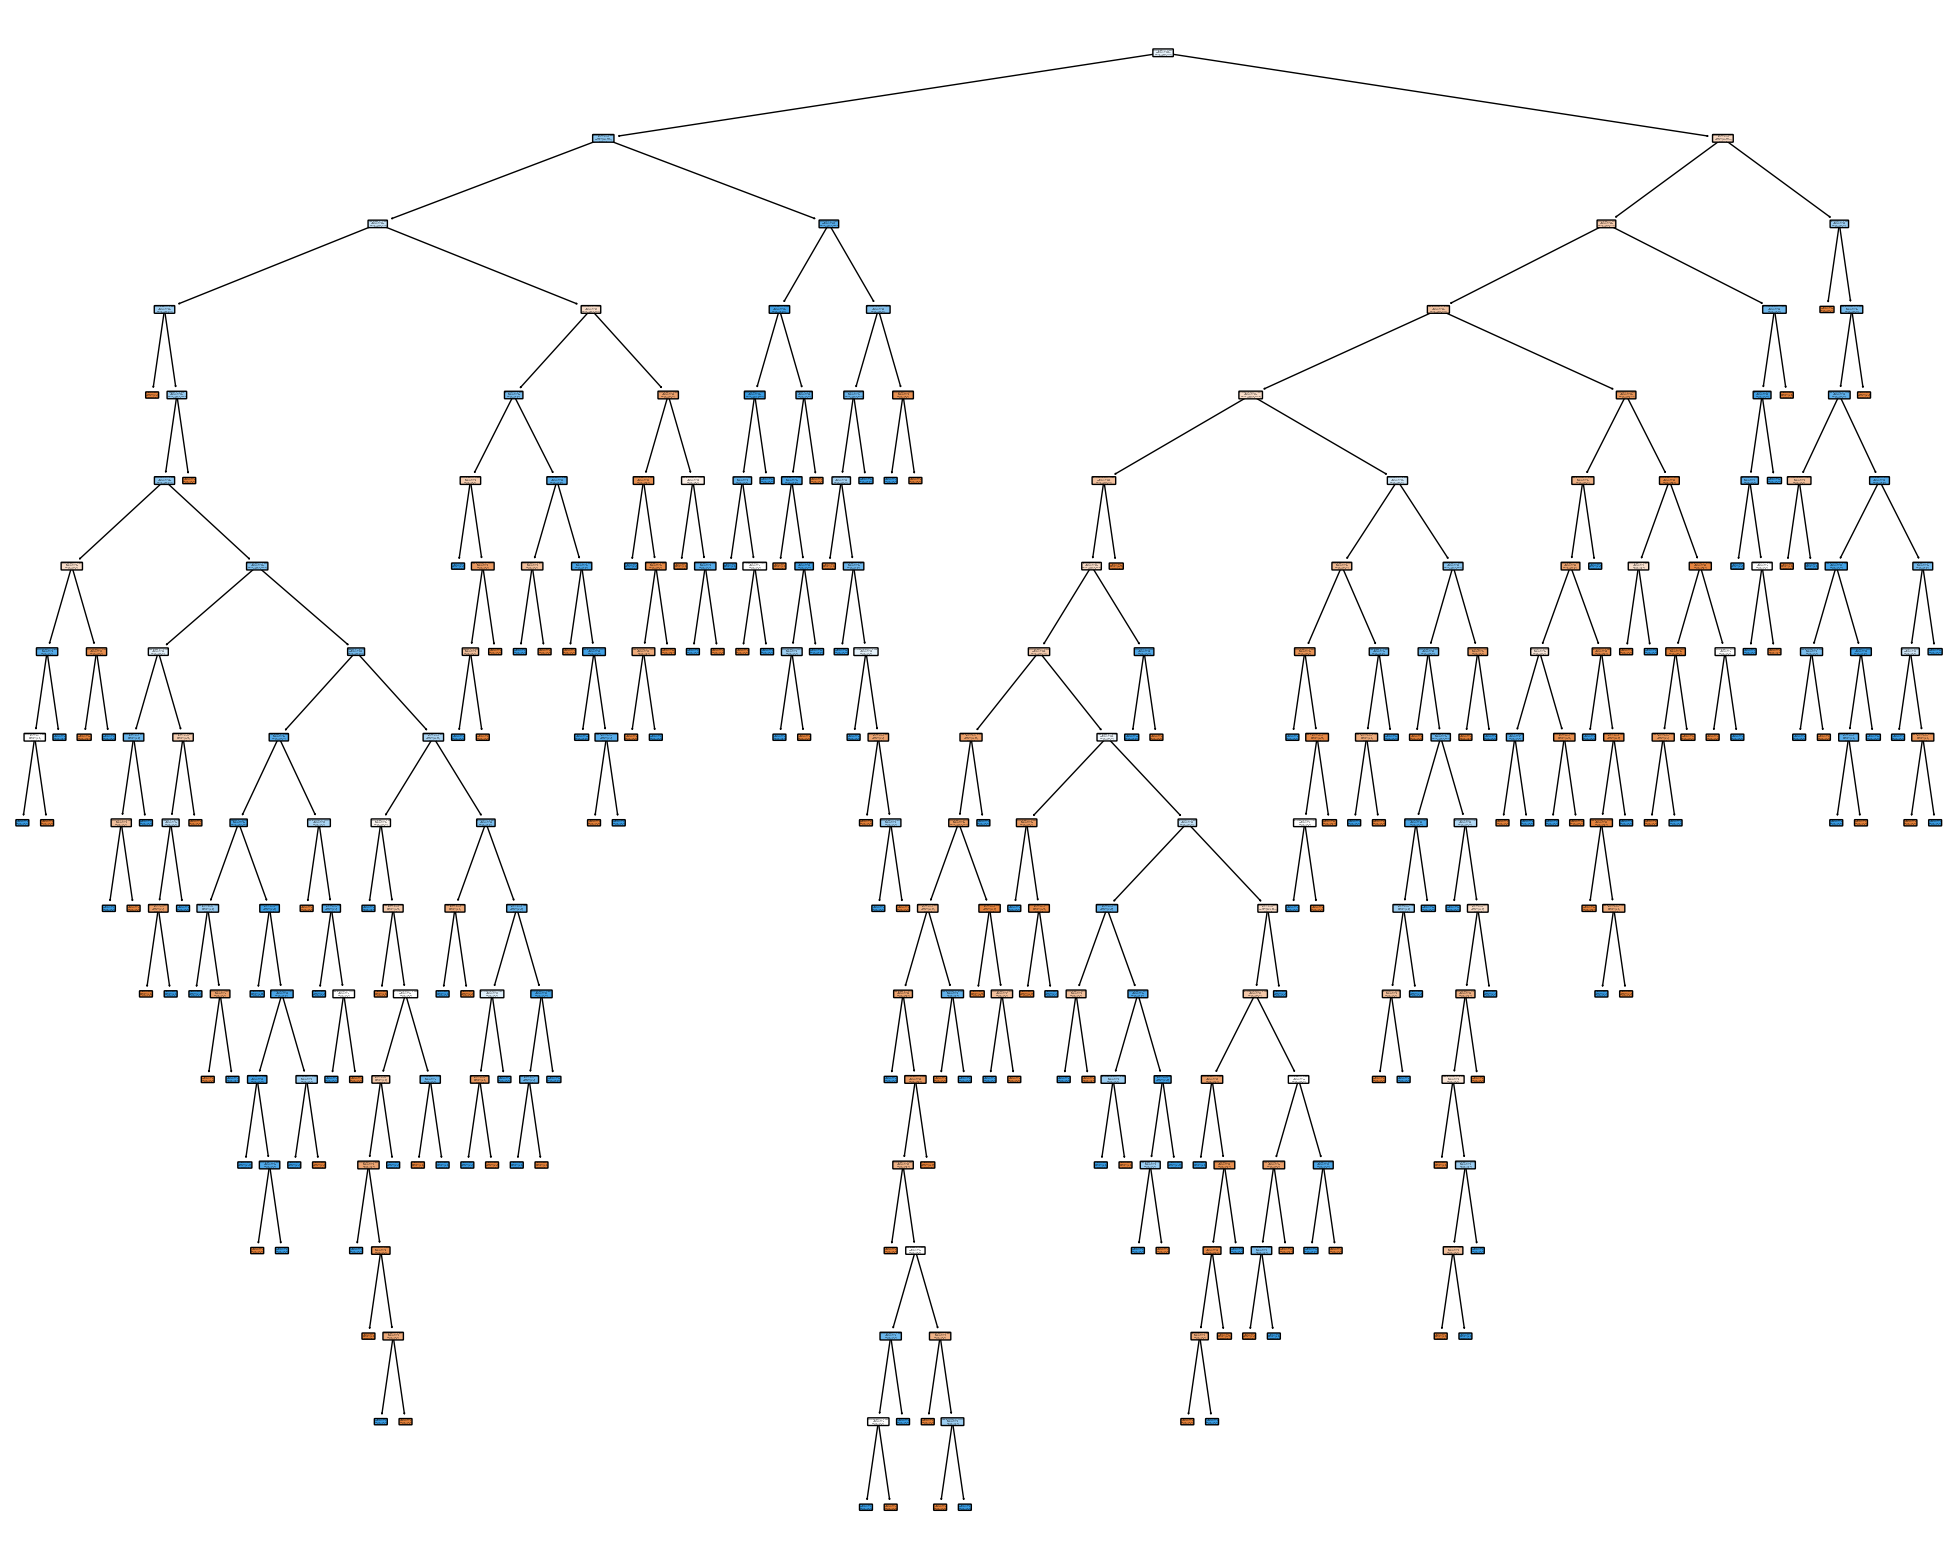

In [138]:
# Plot the tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf,
              feature_names=mushroom_input.columns.values,
              class_names=list(map(str, mushroom_target.unique())),
              rounded=True,
              filled=True)
plt.show()

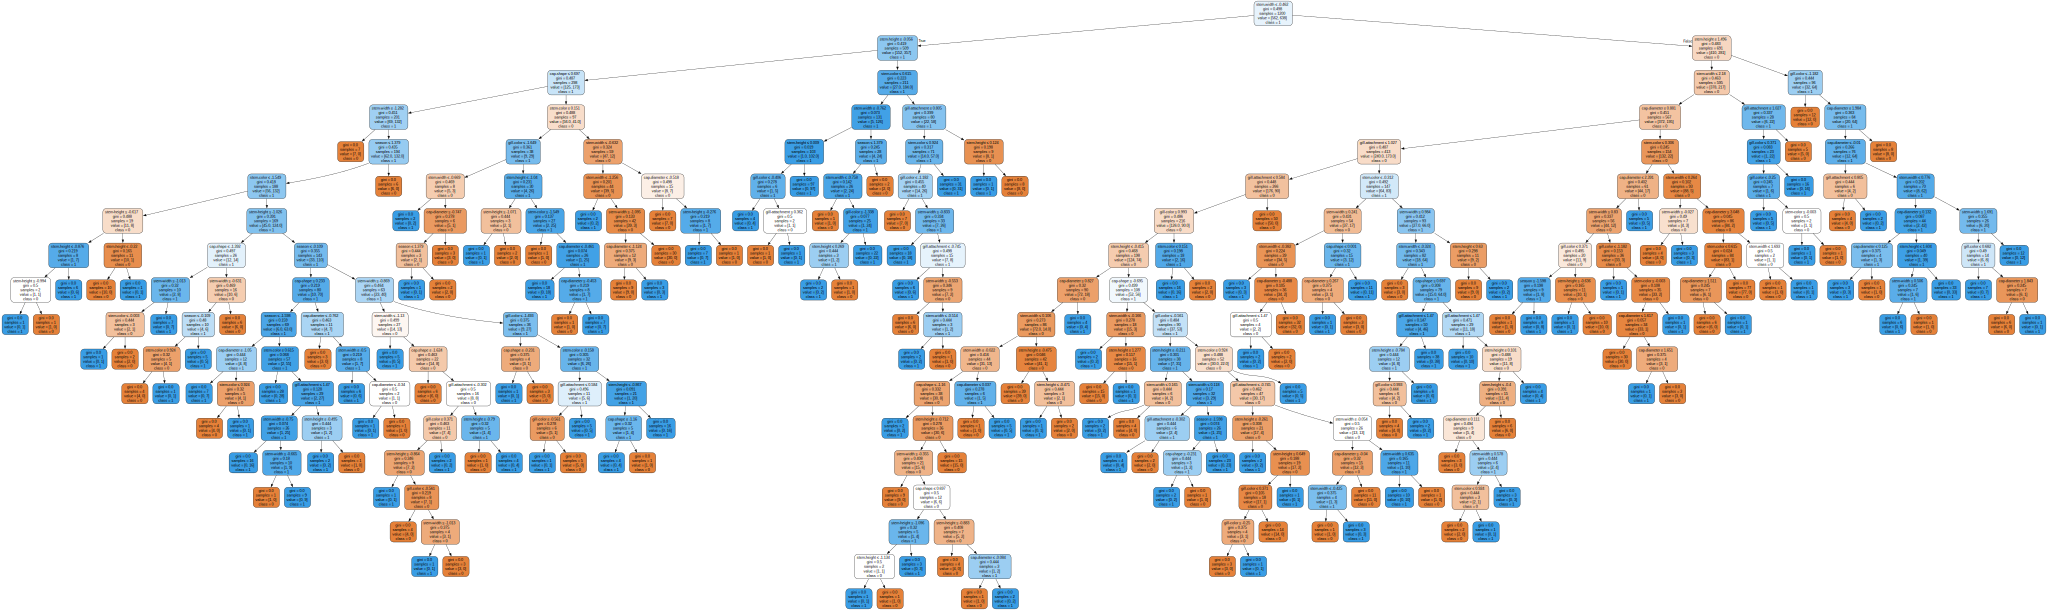

In [139]:
dot_data = export_graphviz(clf, 
                           out_file=None,
                           feature_names=mushroom_input.columns.values,
                           class_names=list(map(str, mushroom_target.unique())),
                           filled=True,
                           rounded=True,
                           special_characters=True) 
graphviz.Source(dot_data)

Find the best tree based on cost complexity pruning

In [140]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

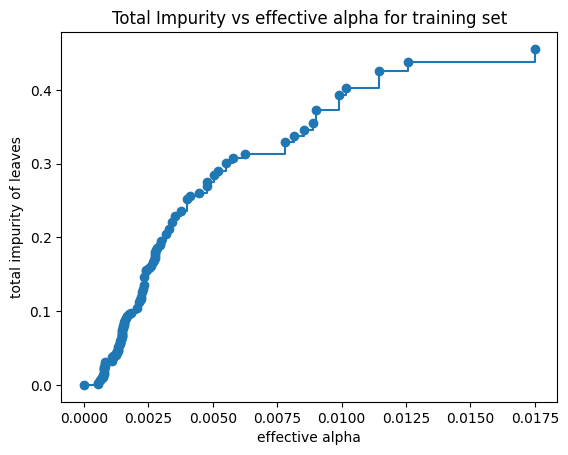

In [141]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [142]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=12345, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.042430419375189266


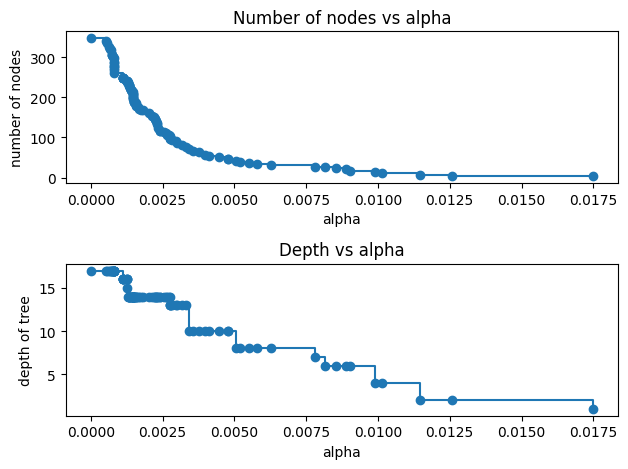

In [143]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

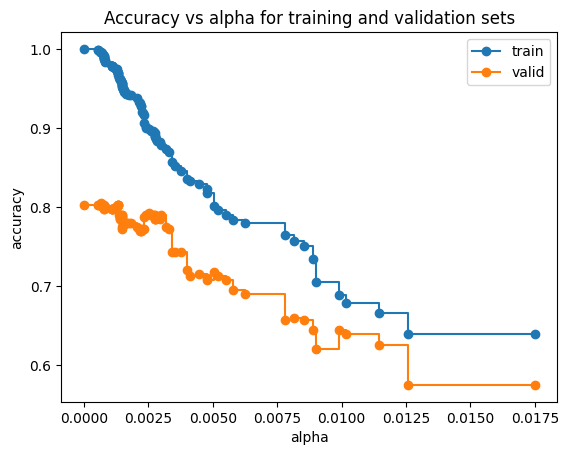

In [144]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker="o", label="valid", drawstyle="steps-post")
ax.legend()
plt.show()

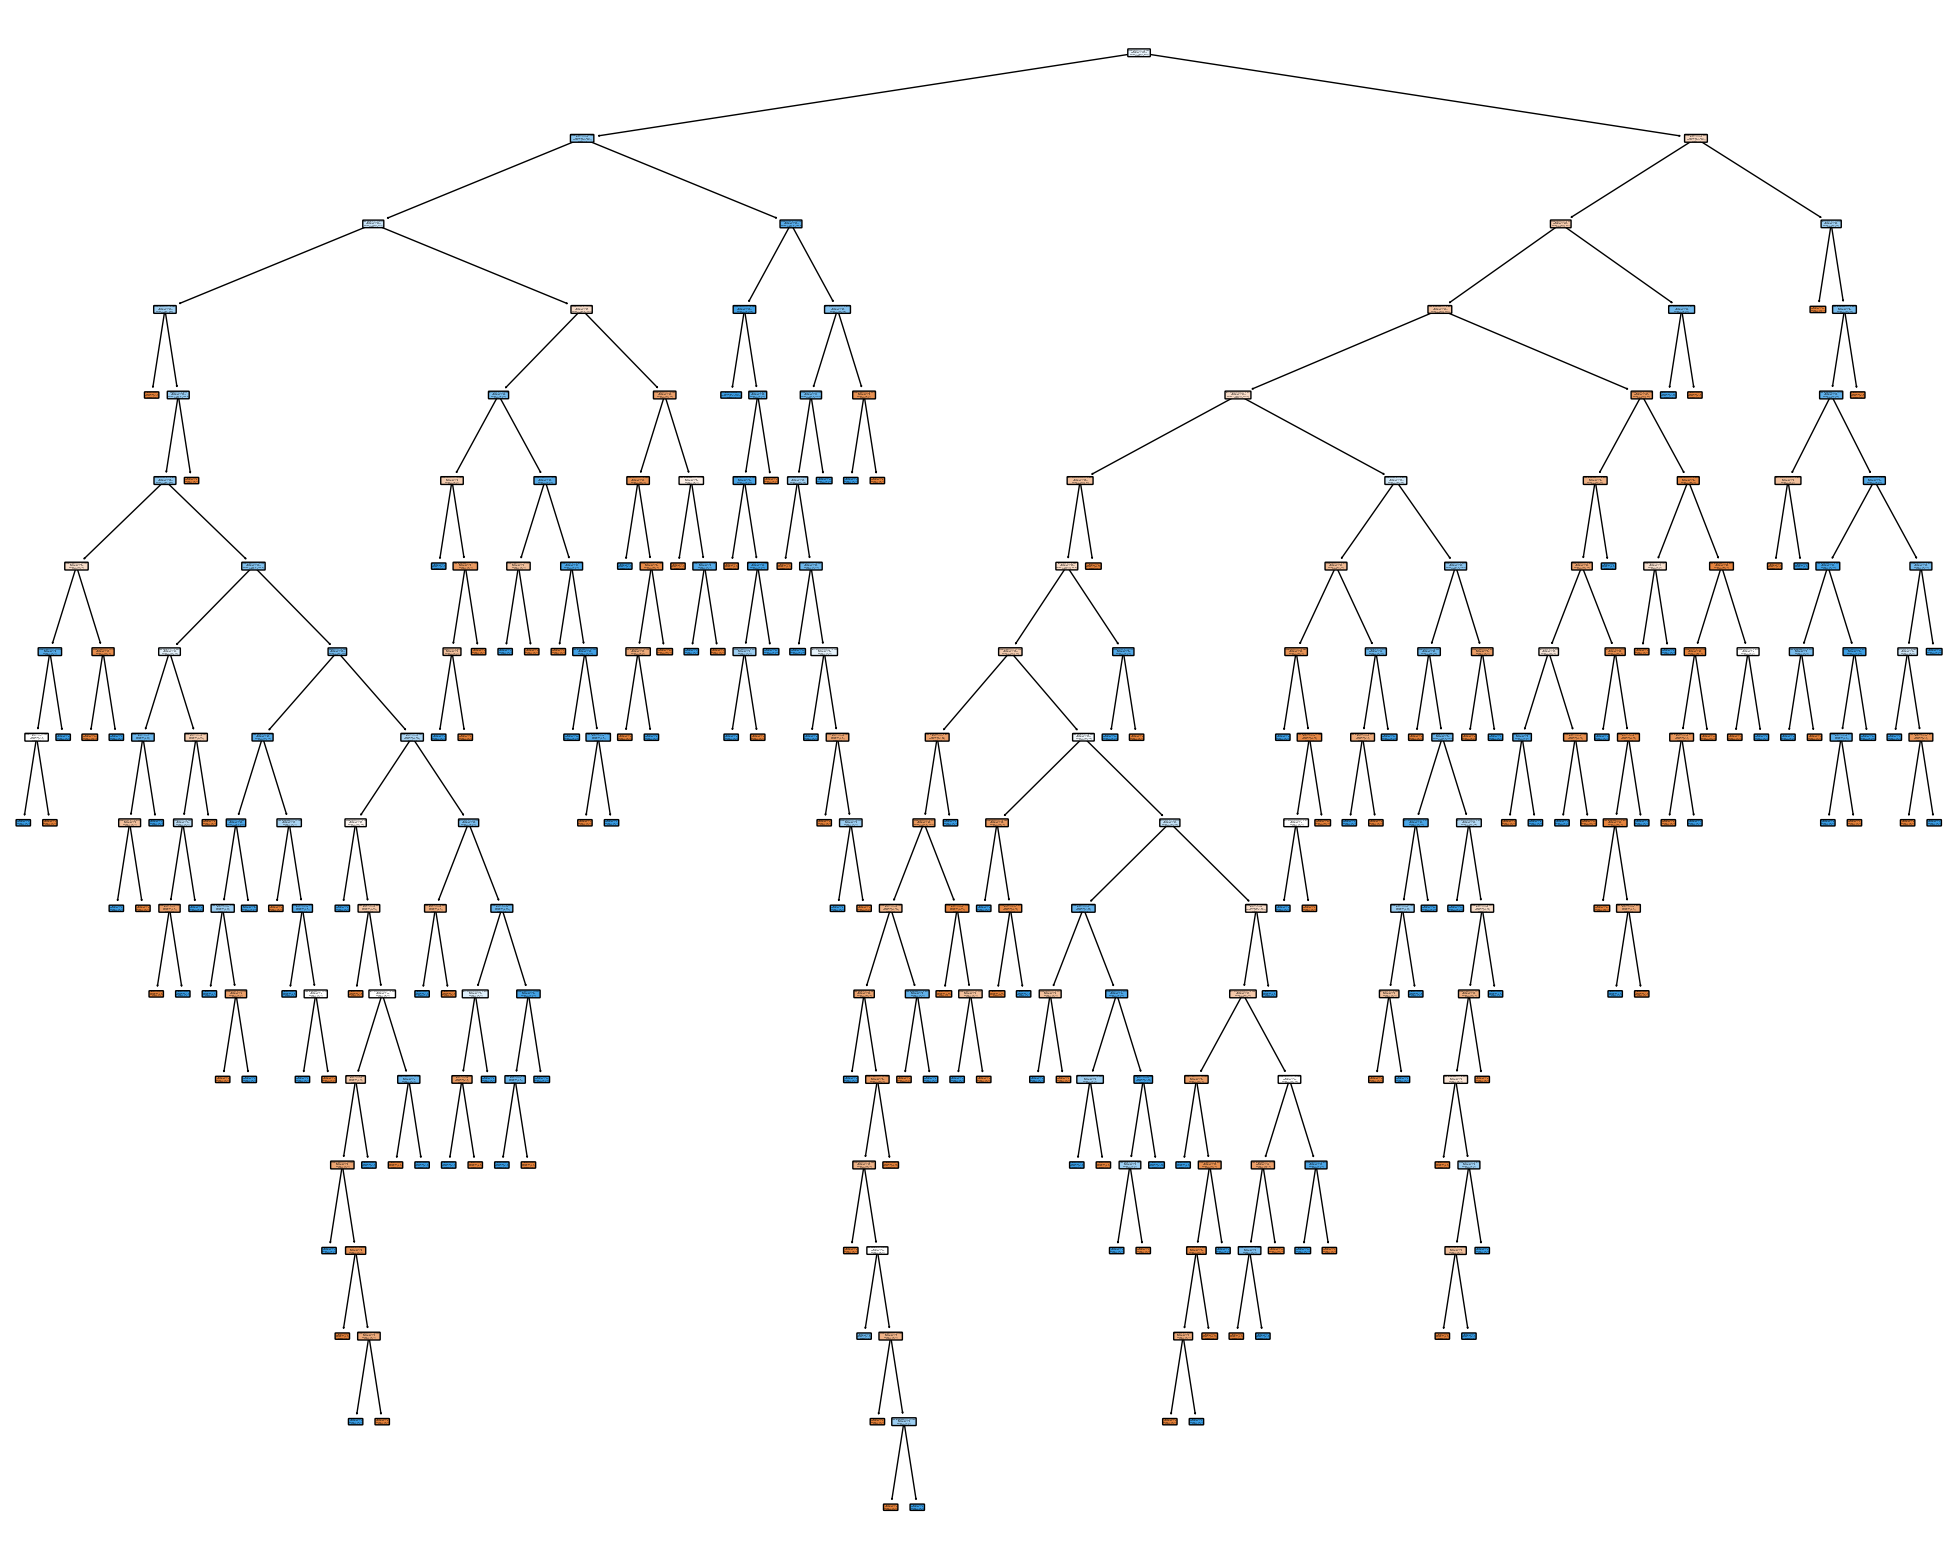

In [145]:
best_clf = clfs[np.argmax(valid_scores)]

fig = plt.figure(figsize=(25,20))
_ = plot_tree(best_clf,
              feature_names=mushroom_input.columns.values,
              class_names=list(map(str, mushroom_target.unique())),
              rounded=True,
              filled=True)

Prediction performance with the best tree

In [146]:
# Prediction
CART_post_prey = best_clf.predict(X_test)
cm = confusion_matrix(y_test, CART_post_prey)
Perf_Table.iloc[1] = perf_eval_with_auroc(cm, y_test, CART_post_prey)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,0.86036,0.82328,0.76966,0.82,0.81375,0.84141,0.81501
Post-Pruning,0.86486,0.81702,0.75843,0.8175,0.8099,0.84026,0.81165
Pre-Pruning,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pre-Pruning(CV),NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pre-Pruning

### Training and Evaluation (Pre-Pruning)

Define parameter search space for pre-pruning

In [156]:
# Tree parameter settings
criterion = ["gini", "entropy", "log_loss"]
min_split = [2, 5, 10, 25, 50, 100]
max_depth = [2, 4, 8, 16]
min_samples_leaf = [1, 2, 4, 8, 16]

param_grid = {
    'criterion': criterion,
    'min_samples_split': min_split,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf
}

Find the optimal parameters

In [157]:
# 하이퍼파라미터 조합 생성
from itertools import product
param_combinations = list(product(
    param_grid['criterion'],
    param_grid['min_samples_split'],
    param_grid['max_depth'],
    param_grid['min_samples_leaf']
))

# 최적 하이퍼파라미터 및 최고 점수 초기화
best_params = None
best_score = 0

# 각 하이퍼파라미터 조합에 대해 모델 훈련 및 평가
for params in param_combinations:
    criterion, min_samples_split, max_depth, min_samples_leaf = params
    model = DecisionTreeClassifier(
        criterion=criterion,
        min_samples_split=min_samples_split,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=12345
    )
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, y_pred)
    
    if score > best_score:
        best_score = score
        best_params = params

# 최적 하이퍼파라미터 출력
best_criterion, best_split, best_depth, best_min_samples_leaf = best_params
print("Best criterion:", best_criterion)
print("Best min_samples_split:", best_split)
print("Best max_depth:", best_depth)
print("Best min_samples_leaf:", best_min_samples_leaf)

# 검증 데이터에 대한 최적 모델 평가
best_model = DecisionTreeClassifier(
    criterion=best_criterion,
    min_samples_split=best_split,
    max_depth=best_depth,
    min_samples_leaf=best_min_samples_leaf,
    random_state=12345
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
roc = roc_auc_score(y_valid, y_pred)

# 결과 출력
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best criterion: gini
Best min_samples_split: 25
Best max_depth: 16
Best min_samples_leaf: 4
Confusion matrix:
 [[144  38]
 [ 58 160]]
ROC AUC: 0.7625768726686158


In [158]:
# Prediction
CART_pre_prediction = best_model.predict(X_test)
cm = confusion_matrix(y_test, CART_pre_prediction)
Perf_Table.iloc[2] = perf_eval_with_auroc(cm, y_test, CART_pre_prediction)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,0.86036,0.82328,0.76966,0.82,0.81375,0.84141,0.81501
Post-Pruning,0.86486,0.81702,0.75843,0.8175,0.8099,0.84026,0.81165
Pre-Pruning,0.76577,0.83333,0.80899,0.785,0.78708,0.79812,0.78738
Pre-Pruning(CV),0.83333,0.86047,0.83146,0.8325,0.83239,0.84668,0.8324


Find the optimal parameters (CV)

In [159]:
# Fit the decision tree model and evaluate the results
model = DecisionTreeClassifier(random_state=12345)
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', refit=True)
grid.fit(X_train, y_train)

# Find the best set of parameters
best_criterion = grid.best_params_['criterion']
best_split = grid.best_params_['min_samples_split']
best_depth = grid.best_params_['max_depth']
best_min_samples_leaf = grid.best_params_['min_samples_leaf']

print("Best criterion:", best_criterion)
print("Best min_samples_split:", best_split)
print("Best max_depth:", best_depth)
print("min_samples_leaf:", best_min_samples_leaf)

# Evaluate the best model on the validation data
y_pred = grid.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
roc = roc_auc_score(y_valid, y_pred)

# Print results
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best criterion: gini
Best min_samples_split: 10
Best max_depth: 16
min_samples_leaf: 4
Confusion matrix:
 [[151  31]
 [ 48 170]]
ROC AUC: 0.8047434217158987


Performance comparison

In [160]:
# Prediction
CART_pre_prediction = grid.predict(X_test)
cm = confusion_matrix(y_test, CART_pre_prediction)
Perf_Table.iloc[3] = perf_eval_with_auroc(cm, y_test, CART_pre_prediction)
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Full-tree,0.86036,0.82328,0.76966,0.82,0.81375,0.84141,0.81501
Post-Pruning,0.86486,0.81702,0.75843,0.8175,0.8099,0.84026,0.81165
Pre-Pruning,0.76577,0.83333,0.80899,0.785,0.78708,0.79812,0.78738
Pre-Pruning(CV),0.83333,0.86047,0.83146,0.8325,0.83239,0.84668,0.8324


Plot the ROC curve

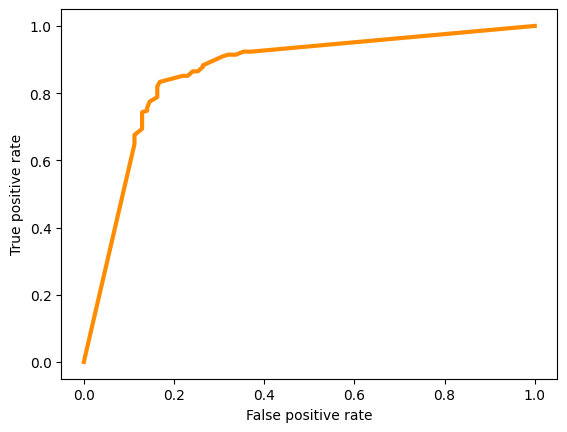

In [161]:
# Plot the ROC
CART_pre_prob = grid.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, CART_pre_prob)
plt.plot(fpr, tpr, color='darkorange', lw=3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Plot the best tree

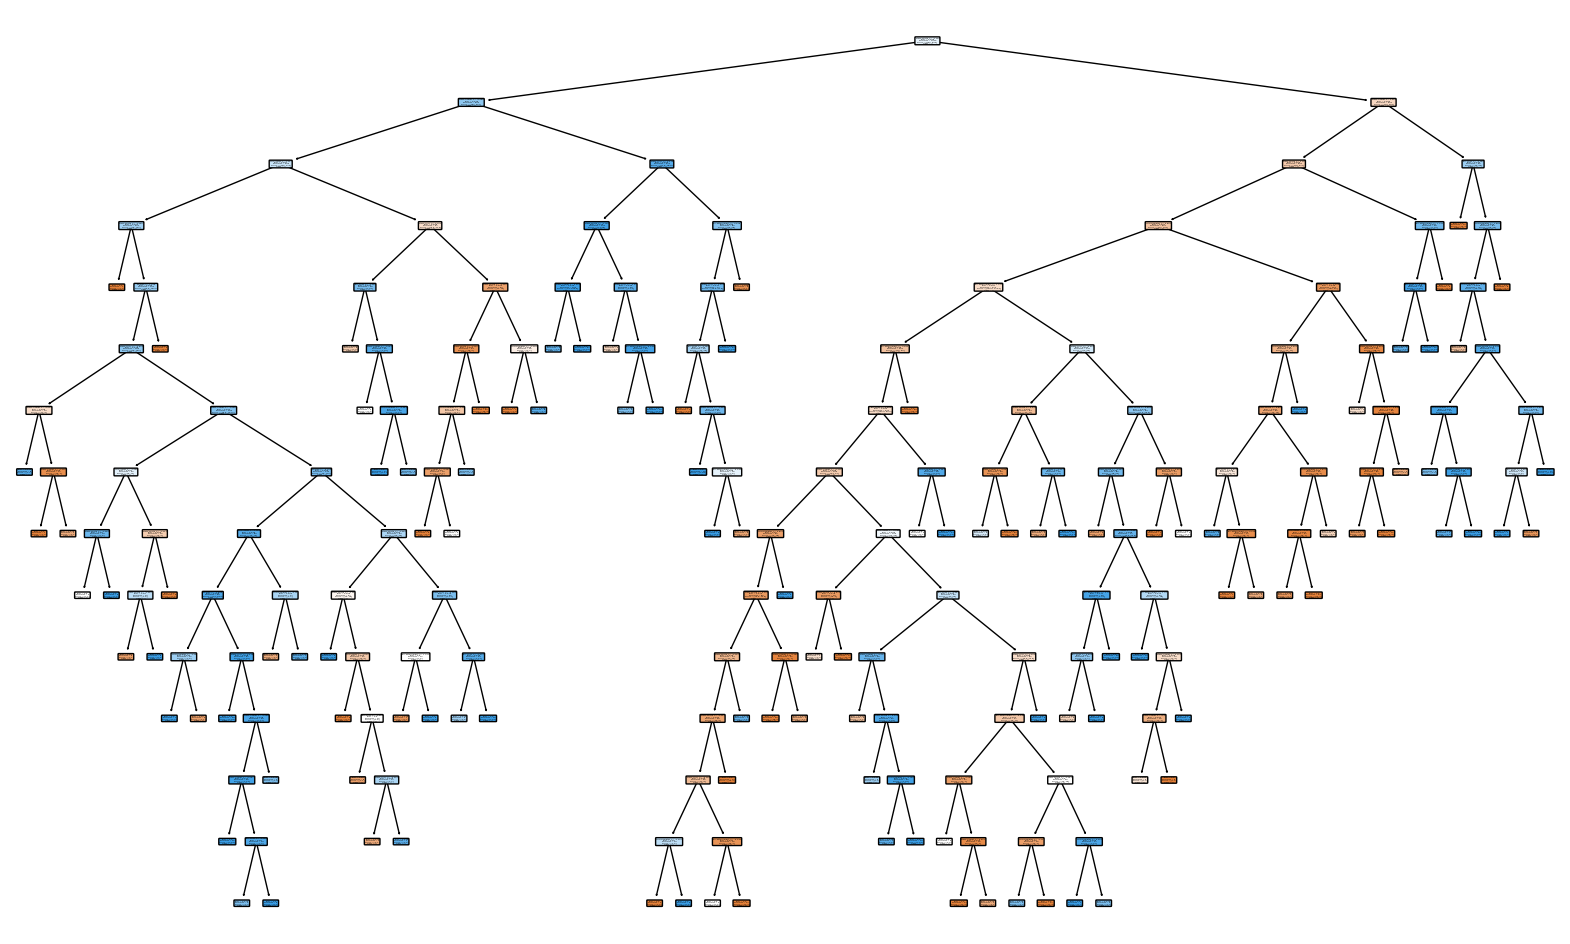

In [164]:
# Plot the best tree
CART_pre = DecisionTreeClassifier(**grid.best_params_)
CART_pre.fit(X_train,y_train)
plt.figure(figsize=(20,12))
plot_tree(CART_pre,
          feature_names=mushroom_input.columns.values,
          class_names=list(map(str, mushroom_target.unique())),
          rounded=True,
          filled=True)
plt.show()

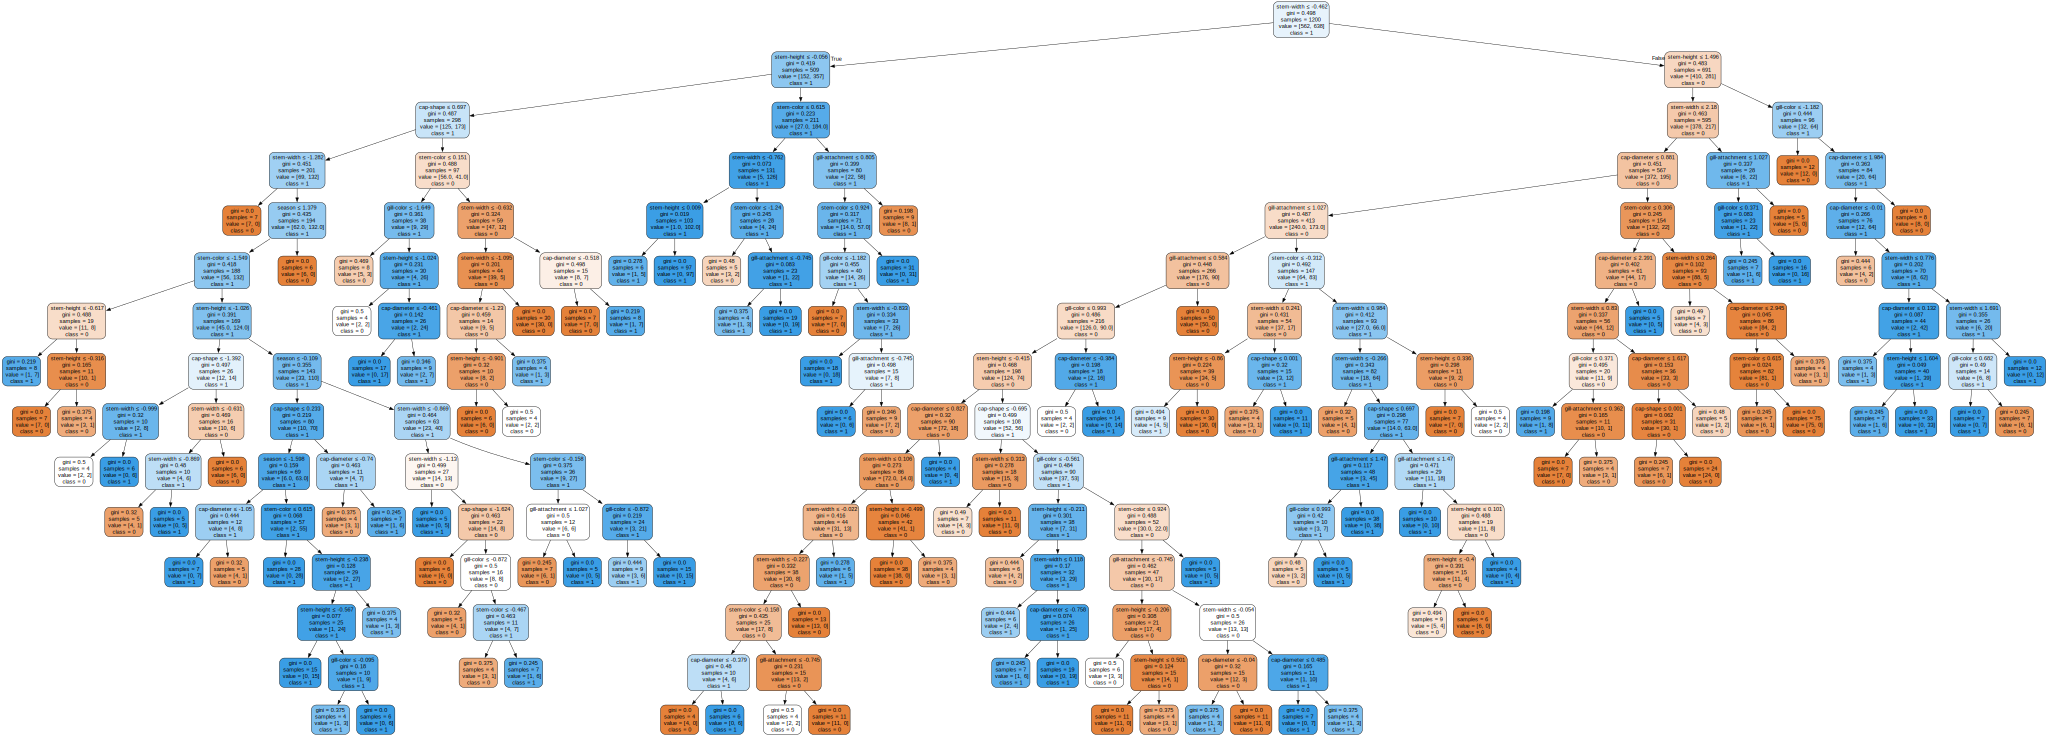

In [165]:
dot_data = export_graphviz(CART_pre, 
                           out_file=None,
                           feature_names=mushroom_input.columns.values,
                           class_names=list(map(str, mushroom_target.unique())),
                           filled=True,
                           rounded=True,
                           special_characters=True) 
graphviz.Source(dot_data)

# Neural Networks: Python Exercise

In [166]:
# Initialize performance matrix
perf_summary = pd.DataFrame(index=["Neural_Network","Neural_Network(CV)"],
                          columns = ["TPR", "Precision", "TNR", 
                                     "Accuracy", "BCR", "F1-Measure","AUROC"])
perf_summary

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Neural_Network,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neural_Network(CV),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
param_grid = {
    'hidden_layer_sizes': [(20,), (50,), (100,), (200,)],  # 은닉층의 노드 수
    'learning_rate_init': [0.001, 0.01, 0.1],  # 학습률
    'activation': ['logistic', 'tanh', 'relu'],  # 활성화 함수
    'max_iter': [100, 200, 300]  # 최대 반복 횟수
}

In [168]:
from sklearn.model_selection import ParameterGrid

# 파라미터 그리드 생성
grid = ParameterGrid(param_grid)

# 검증 데이터에서 최고의 AUROC 값을 가진 모델을 찾기 위한 변수 초기화
best_auc = 0
best_params = None
best_model = None

# 각 파라미터 조합에 대해 모델 훈련 및 평가
for params in grid:
    model = MLPClassifier(random_state=12345, **params)
    model.fit(X_train, y_train)
    
    # 검증 데이터로 예측 수행
    y_pred = model.predict_proba(X_valid)[:, 1]
    
    # AUROC 계산
    auc = roc_auc_score(y_valid, y_pred)
    
    # 최고의 AUROC 값을 가진 모델 및 파라미터 저장
    if auc > best_auc:
        best_auc = auc
        best_params = params
        best_model = model

# 최적 하이퍼파라미터 출력
print("Best parameters:", best_params)
print("Best ROC AUC on validation data:", best_auc)

# 검증 데이터로 최적 모델 평가
y_pred = best_model.predict_proba(X_valid)[:, 1]
cm = confusion_matrix(y_valid, best_model.predict(X_valid))
roc = roc_auc_score(y_valid, y_pred)

# 결과 출력
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.01, 'max_iter': 300}
Best ROC AUC on validation data: 0.9514315959270088
Confusion matrix:
 [[172  10]
 [ 36 182]]
ROC AUC: 0.9514315959270088


In [169]:
# Prediction
pred_Y = best_model.predict(X_test)
cm = confusion_matrix(y_test, pred_Y)
perf_summary.iloc[0] = perf_eval_with_auroc(cm, y_test, pred_Y)
perf_summary

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Neural_Network,0.83333,0.95361,0.94944,0.885,0.88949,0.88942,0.89139
Neural_Network(CV),NaN,NaN,NaN,NaN,NaN,NaN,NaN


Find the optimal parameters (CV)

In [170]:
# MLPClassifier 모델 정의
model = MLPClassifier(random_state=12345)

# GridSearchCV 사용
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', refit=True, verbose=2)
grid.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
best_hidden_layer_sizes = grid.best_params_['hidden_layer_sizes']
best_learning_rate_init = grid.best_params_['learning_rate_init']
best_activation = grid.best_params_['activation']
best_max_iter = grid.best_params_['max_iter']

print("Best hidden_layer_sizes:", best_hidden_layer_sizes)
print("Best learning_rate_init:", best_learning_rate_init)
print("Best activation:", best_activation)
print("Best max_iter:", best_max_iter)

# 검증 데이터로 최적 모델 평가
y_pred = grid.predict_proba(X_valid)[:, 1]
cm = confusion_matrix(y_valid, grid.predict(X_valid))
roc = roc_auc_score(y_valid, y_pred)

# 결과 출력
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=100; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=100; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=100; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=100; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=100; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=200; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=200; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(20,), learning_rate_init=0.001, max_iter=200; total time=   0.3s
[CV] END activati

In [171]:
# Prediction
pred_Y = grid.predict(X_test)
cm = confusion_matrix(y_test, pred_Y)
perf_summary.iloc[1] = perf_eval_with_auroc(cm, y_test, pred_Y)
perf_summary

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Neural_Network,0.83333,0.95361,0.94944,0.885,0.88949,0.88942,0.89139
Neural_Network(CV),0.88739,0.91628,0.89888,0.8925,0.89312,0.9016,0.89313


### Training the model - Logistic Regression

* Logistic regression model from sklearn.linear_models [[Docs]('https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html')]
* Main arguments  
    * fit_intercept: 상수항 추가 여부 (default: True) 
    * solver : 최적해를 구하기 위한 알고리즘 / 데이터셋이 크지 않고 이진분류 과업을 진행하기 때문에 안내에 따라 'libnear' 선택
    * random_state : 랜덤성을 고정하기 위한 seed / 'solver'에서 'libnear'를 선택했을 시 사용됨 
    * max_iter: solver가 수렴하기 위한 최대 시도 횟수 

In [172]:
# Initialize performance matrix
perf_logistic = pd.DataFrame(index=["Logistic_Regression"],
                          columns = ["TPR", "Precision", "TNR", 
                                     "Accuracy", "BCR", "F1-Measure","AUROC"])
perf_logistic

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Logistic_Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
# model setting
from sklearn.linear_model import LogisticRegression
full_lr = LogisticRegression(
    solver='liblinear',
    random_state=12345,
    max_iter=100000
)

# Train the model with trainset
full_lr.fit(X_train,y_train)

LogisticRegression(max_iter=100000, random_state=12345, solver='liblinear')

In [174]:
from sklearn.metrics import confusion_matrix

# 학습 데이터
lr_target_trn = y_train
lr_response_trn = full_lr.predict(X_train)
cm = confusion_matrix(lr_target_trn,lr_response_trn)
cm

array([[349, 213],
       [191, 447]], dtype=int64)

In [175]:
# Prediction (테스트 데이터)
pred_Y = full_lr.predict(X_test)
cm = confusion_matrix(y_test, pred_Y)
cm

array([[107,  71],
       [ 78, 144]], dtype=int64)

In [176]:
perf_logistic.iloc[0] = perf_eval_with_auroc(cm, y_test, pred_Y)
perf_logistic

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure,AUROC
Logistic_Regression,0.64865,0.66977,0.60112,0.6275,0.62443,0.65904,0.62489
